In [109]:
import os
import re
import functools
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle5 as pickle

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score, \
    accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [52]:
def plot_importances(X_data, model, top=10):

    feature_imp_mapping = {feature:importance for feature, importance in zip(X_data.columns.to_list(), model.feature_importances_)}
    feature_imp_mapping_sorted = {k: v for k, v in sorted(feature_imp_mapping.items(), key=lambda item: item[1], reverse=True)[:top]}
    if top>15:
        figsize = (4,6)
    else:
        figsize = (4,6)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=figsize)

    # Example data
    people = feature_imp_mapping_sorted.keys()
    y_pos = np.arange(len(feature_imp_mapping_sorted))
    importance = feature_imp_mapping_sorted.values()
    #error = np.random.rand(len(people))

    ax.barh(y_pos, importance, align='center')
    ax.set_yticks(y_pos, labels=people, fontsize=13)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance')
    ax.grid(True)

    plt.show()

    return feature_imp_mapping_sorted

In [56]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    #return lst3
    return lst3

# Load data

In [198]:
CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
XGB_DATA_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/xgb/dataframes/'
DF_PATH = CURR_PATH+'/dataframes_2/'
# CURR_PATH = os.getcwd()
CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
DATA_PATH = '/home/svetlanamaslenkova/Documents/data/physionet.org/files/mimiciv/2.0/'
DF_PATH = CURR_PATH +'/dataframes_2/'
PKL_PATH = CURR_PATH+'/pickles_2/'
ICU_PATH = DATA_PATH + 'icu/'
HOSP_PATH = DATA_PATH + 'hosp/'

In [199]:
import pandas as pd

data_icustays = pd.read_csv(ICU_PATH + 'icustays.csv')

data_icustays.columns = data_icustays.columns.str.lower()

data_icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [200]:
data_icustays['hadm_id'] = data_icustays['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_icustays['intime'] = pd.to_datetime(data_icustays['intime'], format=format_)
data_icustays['outtime'] = pd.to_datetime(data_icustays['outtime'], format=format_)

In [4]:
with open(XGB_DATA_PATH + 'data_xgb.pkl', 'rb') as f:
    dataset = pickle.load(f)
dataset.columns = [col.replace(' ', '_') for col in dataset.columns]
dataset.columns = dataset.columns.str.lower()
print(dataset.shape)
dataset.head()

(33805, 65)


,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),max_chloride_(serum),...,min_nbpm,max_nbpd,min_nbpd,output,race,gender,age,aki_1,aki_2,aki_3
0,10002155,28994087,31090461,21.4,60.0,109.4,51.0,99.0,136.0,106.0,...,76.0,25.0,64.0,3260.0,1,1,82,0,0,0
1,10002428,20321825,34807493,20.0,59.0,99.0,78.0,131.0,133.0,93.0,...,112.0,32.0,101.0,888.0,1,1,81,0,0,0
2,10002428,23473524,35479615,20.0,59.0,99.0,78.0,131.0,135.0,107.0,...,NaN,NaN,NaN,2255.0,1,1,81,0,0,0
3,10002428,28662225,33987268,20.0,59.0,99.0,78.0,131.0,133.0,98.0,...,92.0,19.0,90.0,805.0,1,1,81,1,1,0
5,10002428,28662225,38875437,20.0,59.0,99.0,78.0,131.0,144.0,110.0,...,127.0,30.0,116.0,1630.0,1,1,81,1,1,0


In [179]:
dataset.stay_id.unique().shape[0]

13128

In [5]:
with open(XGB_DATA_PATH + 'data_diags_xgb.pkl', 'rb') as f:
    data_diags_xgb = pickle.load(f)
print('shape: ', data_diags_xgb.shape)
print((data_diags_xgb==0).sum())
data_diags_xgb.head()

shape:  (69639, 9)
hadm_id             0
cirrhosis       67634
cad             59282
chf             58865
liver           68325
mi              64269
diabetes        56533
hypertension    48514
pv              66617
dtype: int64


,hadm_id,cirrhosis,cad,chf,liver,mi,diabetes,hypertension,pv
0,29079034,0,0,0,0,0,0,1,0
1,26913865,0,0,1,0,0,1,0,0
2,24597018,0,0,0,0,0,0,0,0
3,27703517,0,0,0,0,0,0,1,0
4,25563031,0,0,0,0,0,0,0,0


In [6]:
with open(XGB_DATA_PATH + 'data_medications_xgb.pkl', 'rb') as f:
    data_medications_xgb = pickle.load(f)

print('shape: ', data_medications_xgb.shape)
print((data_medications_xgb==0).sum())
data_medications_xgb.head()

shape:  (36911, 5)
stay_id        0
M01        36451
B01        23216
C03        28878
C02        34180
dtype: int64


,stay_id,M01,B01,C03,C02
0,37510196,0,1,0,0
1,33685454,0,1,1,0
2,31090461,0,1,0,0
3,32610785,0,0,0,0
4,34807493,0,1,0,0


In [7]:
dataset = dataset.merge(data_medications_xgb, on='stay_id', how='left').merge(data_diags_xgb, on='hadm_id', how='left')

Check how many NaN values are in the dataset:

In [19]:
for k,v in dataset.isna().sum().sort_values(ascending=True).iteritems():
    print(k, v)

subject_id 0
gender 0
age 0
aki_1 0
aki_2 0
aki_3 0
M01 0
B01 0
C03 0
C02 0
cirrhosis 0
cad 0
chf 0
liver 0
mi 0
diabetes 0
race 0
hypertension 0
pv 0
hadm_id 0
stay_id 0
min_hr 63
max_hr 63
min_hr_alarm_-_low 120
max_hr_alarm_-_low 120
min_hr_alarm_-_high 121
max_hr_alarm_-_high 121
max_chloride_(serum) 264
min_chloride_(serum) 264
min_creatinine_(serum) 267
max_creatinine_(serum) 267
min_sodium_(serum) 268
max_sodium_(serum) 268
max_hco3_(serum) 279
min_hco3_(serum) 279
min_bun 280
max_bun 280
min_potassium_(serum) 290
max_potassium_(serum) 290
max_anion_gap 318
min_anion_gap 318
max_hematocrit_(serum) 370
min_hematocrit_(serum) 370
min_hemoglobin 412
max_hemoglobin 412
max_platelet_count 414
min_wbc 414
min_platelet_count 414
max_wbc 414
max_glucose_(serum) 417
min_glucose_(serum) 417
output 813
min_magnesium 1212
max_magnesium 1212
min_phosphorous 2409
max_phosphorous 2409
max_calcium_non-ionized 2514
min_calcium_non-ionized 2514
max_temperature_f 2888
min_temperature_f 2888
max_nb

In [34]:
print('n of rows: ', dataset.shape[0])
for k,v in (dataset==0).sum(axis=0).sort_values(ascending=False).iteritems():
    print(k, v)

n of rows:  33805
M01 33387
liver 33100
cirrhosis 32708
pv 32245
C02 31283
mi 31032
aki_3 29924
cad 28542
chf 28066
diabetes 27208
aki_2 26399
C03 26397
hypertension 23398
B01 21194
aki_1 20232
output 1301
max_hr 49
max_temperature_f 28
max_nbpm 11
max_hemoglobin 9
max_nbps 9
diastolic_bp 8
max_creatinine_(serum) 6
weight 6
max_nbpd 6
max_hr_alarm_-_low 4
max_hr_alarm_-_high 4
max_hematocrit_(serum) 3
max_calcium_non-ionized 3
max_anion_gap 3
max_ptt 2
max_phosphorous 2
max_sodium_(serum) 2
max_potassium_(serum) 2
max_glucose_(serum) 2
min_creatinine_(serum) 2
max_magnesium 1
min_temperature_f 1
max_hco3_(serum) 1
min_nbpm 0
min_nbpd 0
gender 0
min_nbps 0
age 0
min_hr_alarm_-_high 0
min_hr_alarm_-_low 0
race 0
subject_id 0
min_hr 0
min_hematocrit_(serum) 0
stay_id 0
bmi 0
height 0
systolic_bp 0
min_sodium_(serum) 0
max_chloride_(serum) 0
min_chloride_(serum) 0
min_potassium_(serum) 0
min_bun 0
max_bun 0
min_hco3_(serum) 0
min_anion_gap 0
min_glucose_(serum) 0
min_ptt 0
min_hemoglobin 0

Get stays splits:

In [8]:
with open(DF_PATH + 'pid_train_dataset_icu.pkl', 'rb') as f:
    pid_train_dataset_icu = pickle.load(f)

with open(DF_PATH + 'pid_test_dataset_icu.pkl', 'rb') as f:
    pid_test_dataset_icu = pickle.load(f)

with open(DF_PATH + 'pid_val_dataset_icu.pkl', 'rb') as f:
    pid_val_dataset_icu = pickle.load(f)

In [9]:
stays_train = pid_train_dataset_icu.stay_id.unique()
stays_test = pid_test_dataset_icu.stay_id.unique()
stays_val = pid_val_dataset_icu.stay_id.unique()

In [178]:
print(len(stays_train))
print(len(stays_test))
print(len(stays_val))

11425
1428
1429


In [11]:
train_dataset = dataset[dataset.stay_id.isin(stays_train)]
print(f'train dataset: {train_dataset.shape[0]}')

test_dataset = dataset[dataset.stay_id.isin(stays_test)]
print(f'test dataset: {test_dataset.shape[0]}')

val_dataset = dataset[dataset.stay_id.isin(stays_val)]
print(f'valdataset: {val_dataset.shape[0]}')

train dataset: 10487
test dataset: 1328
valdataset: 1313


In [37]:
train_dataset.describe()

,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),max_chloride_(serum),...,C03,C02,cirrhosis,cad,chf,liver,mi,diabetes,hypertension,pv
count,1.048700e+04,1.048700e+04,1.048700e+04,2817.000000,2442.000000,3040.000000,2989.000000,2989.000000,10337.000000,10337.000000,...,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000
mean,1.501423e+07,2.495257e+07,3.496698e+07,32.010685,65.566106,172.145240,72.277685,126.462362,236.416078,103.348486,...,0.165729,0.093068,0.018594,0.094498,0.084867,0.012396,0.042147,0.111948,0.228473,0.020788
std,2.882488e+06,2.893922e+06,2.905073e+06,122.433271,6.149830,216.930543,12.937129,20.025310,9834.259983,5.758741,...,0.371855,0.290541,0.135094,0.292534,0.278697,0.110652,0.200935,0.315318,0.419869,0.142680
min,1.000216e+07,2.000149e+07,3.000048e+07,1.700000,1.000000,0.000000,0.000000,70.000000,108.000000,61.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.250292e+07,2.243186e+07,3.239203e+07,22.700000,62.531250,134.650000,63.000000,112.000000,137.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.500610e+07,2.491930e+07,3.496066e+07,26.200000,66.000000,160.000000,72.000000,125.000000,140.000000,104.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.753797e+07,2.743603e+07,3.748599e+07,30.600000,69.000000,192.000000,80.000000,140.000000,142.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.999859e+07,2.999962e+07,3.999981e+07,4194.200000,177.000000,11501.000000,145.000000,211.000000,999999.000000,150.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data analysis

In [59]:
dataset = pd.concat([train_dataset, test_dataset, val_dataset])

In [61]:
dataset.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'bmi', 'height', 'weight',
       'diastolic_bp', 'systolic_bp', 'min_sodium_(serum)',
       'max_chloride_(serum)', 'min_chloride_(serum)', 'max_sodium_(serum)',
       'max_potassium_(serum)', 'min_potassium_(serum)',
       'min_creatinine_(serum)', 'max_creatinine_(serum)', 'min_bun',
       'max_bun', 'max_hco3_(serum)', 'min_hco3_(serum)', 'max_anion_gap',
       'min_anion_gap', 'max_hematocrit_(serum)', 'min_hematocrit_(serum)',
       'min_glucose_(serum)', 'max_glucose_(serum)', 'min_hemoglobin',
       'max_hemoglobin', 'max_platelet_count', 'min_platelet_count', 'min_wbc',
       'max_wbc', 'min_magnesium', 'max_magnesium', 'min_phosphorous',
       'max_phosphorous', 'min_calcium_non-ionized', 'max_calcium_non-ionized',
       'min_prothrombin_time', 'max_prothrombin_time', 'min_inr', 'max_inr',
       'min_ptt', 'max_ptt', 'max_hr', 'min_hr', 'max_hr_alarm_-_low',
       'min_hr_alarm_-_low', 'max_hr_alarm_-_high', 'min_hr_alarm

Race

In [91]:
# analyze the samples with AKI stage 3
data_aki_3 = dataset[dataset.aki_3==1]

In [104]:
data_aki_3_race = data_aki_3.groupby('race').count().sort_values('stay_id', ascending=False).reset_index()
data_aki_3_race['Race'] = [race_map[race_num] for race_num in data_aki_3_race.race]
data_aki_3_race.head(7)

,race,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),...,C02,cirrhosis,cad,chf,liver,mi,diabetes,hypertension,pv,Race
0,1,58,58,58,34,32,35,33,33,58,...,58,58,58,58,58,58,58,58,58,WHITE
1,5,12,12,12,2,2,3,1,1,12,...,12,12,12,12,12,12,12,12,12,UNKNOWN
2,3,8,8,8,8,5,8,8,8,8,...,8,8,8,8,8,8,8,8,8,BLACK/AFRICAN AMERICAN
3,8,5,5,5,5,5,5,3,3,5,...,5,5,5,5,5,5,5,5,5,WHITE OTHER EUROPEAN
4,2,5,5,5,5,5,5,3,3,5,...,5,5,5,5,5,5,5,5,5,OTHER
5,14,4,4,4,4,3,4,3,3,4,...,4,4,4,4,4,4,4,4,4,HISPANIC/LATINO PUERTO RICAN
6,11,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,ASIAN CHINESE


In [105]:
# analyze whole cohort
dataset_race = dataset.groupby('race').count().sort_values('stay_id', ascending=False).reset_index()
dataset_race['Race'] = [race_map[race_num] for race_num in dataset_race.race]
dataset_race.head(7)

,race,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),...,C02,cirrhosis,cad,chf,liver,mi,diabetes,hypertension,pv,Race
0,1,8435,8435,8435,2284,2015,2466,2484,2484,8315,...,8435,8435,8435,8435,8435,8435,8435,8435,8435,WHITE
1,5,1549,1549,1549,131,131,142,95,95,1535,...,1549,1549,1549,1549,1549,1549,1549,1549,1549,UNKNOWN
2,3,813,813,813,301,229,326,319,319,802,...,813,813,813,813,813,813,813,813,813,BLACK/AFRICAN AMERICAN
3,2,455,455,455,115,107,128,131,131,444,...,455,455,455,455,455,455,455,455,455,OTHER
4,4,222,222,222,0,0,0,2,2,221,...,222,222,222,222,222,222,222,222,222,UNABLE TO OBTAIN
5,8,207,207,207,104,95,109,123,123,206,...,207,207,207,207,207,207,207,207,207,WHITE OTHER EUROPEAN
6,10,184,184,184,57,51,61,58,58,180,...,184,184,184,184,184,184,184,184,184,ASIAN


In [102]:
# analyze the negative samples
dataset_race = dataset[dataset.aki_1==0].groupby('race').count().sort_values('stay_id', ascending=False).reset_index()
dataset_race['Race'] = [race_map[race_num] for race_num in dataset_race.race]
dataset_race.head(10)

,race,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),...,C02,cirrhosis,cad,chf,liver,mi,diabetes,hypertension,pv,Race
0,1,7466,7466,7466,1830,1609,1980,2066,2066,7348,...,7466,7466,7466,7466,7466,7466,7466,7466,7466,WHITE
1,5,1404,1404,1404,100,100,107,82,82,1391,...,1404,1404,1404,1404,1404,1404,1404,1404,1404,UNKNOWN
2,3,707,707,707,235,186,255,258,258,696,...,707,707,707,707,707,707,707,707,707,BLACK/AFRICAN AMERICAN
3,2,401,401,401,88,83,100,109,109,390,...,401,401,401,401,401,401,401,401,401,OTHER
4,4,204,204,204,0,0,0,2,2,203,...,204,204,204,204,204,204,204,204,204,UNABLE TO OBTAIN
5,8,173,173,173,81,74,85,99,99,172,...,173,173,173,173,173,173,173,173,173,WHITE OTHER EUROPEAN
6,10,168,168,168,50,44,54,56,56,164,...,168,168,168,168,168,168,168,168,168,ASIAN
7,14,127,127,127,46,41,48,44,44,123,...,127,127,127,127,127,127,127,127,127,HISPANIC/LATINO PUERTO RICAN
8,18,119,119,119,12,11,15,17,17,118,...,119,119,119,119,119,119,119,119,119,HISPANIC OR LATINO
9,11,115,115,115,57,49,59,59,59,110,...,115,115,115,115,115,115,115,115,115,ASIAN CHINESE


In [82]:
race_list = ['WHITE', 'OTHER', 'BLACK/AFRICAN AMERICAN', 'UNABLE TO OBTAIN',
        'UNKNOWN', 'WHITE  RUSSIAN', 'PORTUGUESE', 'WHITE  OTHER EUROPEAN',
        'BLACK/CAPE VERDEAN', 'ASIAN', 'ASIAN  CHINESE',
        'HISPANIC/LATINO  DOMINICAN', 'HISPANIC/LATINO  SALVADORAN',
        'HISPANIC/LATINO  PUERTO RICAN', 'HISPANIC/LATINO  GUATEMALAN',
        'ASIAN  SOUTH EAST ASIAN', 'WHITE  BRAZILIAN', 'HISPANIC OR LATINO',
        'HISPANIC/LATINO  CENTRAL AMERICAN', 'BLACK/AFRICAN',
        'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'BLACK/CARIBBEAN ISLAND',
        'HISPANIC/LATINO  MEXICAN', 'PATIENT DECLINED TO ANSWER',
        'HISPANIC/LATINO  CUBAN', 'AMERICAN INDIAN/ALASKA NATIVE',
        'MULTIPLE RACE/ETHNICITY', 'WHITE  EASTERN EUROPEAN', 'ASIAN  KOREAN',
        'HISPANIC/LATINO  HONDURAN', 'ASIAN  ASIAN INDIAN',
        'HISPANIC/LATINO  COLUMBIAN', 'SOUTH AMERICAN']

race_map = {num+1:race for num, race in enumerate(race_list)}

In [83]:
race_map

{1: 'WHITE',
 2: 'OTHER',
 3: 'BLACK/AFRICAN AMERICAN',
 4: 'UNABLE TO OBTAIN',
 5: 'UNKNOWN',
 6: 'WHITE  RUSSIAN',
 7: 'PORTUGUESE',
 8: 'WHITE  OTHER EUROPEAN',
 9: 'BLACK/CAPE VERDEAN',
 10: 'ASIAN',
 11: 'ASIAN  CHINESE',
 12: 'HISPANIC/LATINO  DOMINICAN',
 13: 'HISPANIC/LATINO  SALVADORAN',
 14: 'HISPANIC/LATINO  PUERTO RICAN',
 15: 'HISPANIC/LATINO  GUATEMALAN',
 16: 'ASIAN  SOUTH EAST ASIAN',
 17: 'WHITE  BRAZILIAN',
 18: 'HISPANIC OR LATINO',
 19: 'HISPANIC/LATINO  CENTRAL AMERICAN',
 20: 'BLACK/AFRICAN',
 21: 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 22: 'BLACK/CARIBBEAN ISLAND',
 23: 'HISPANIC/LATINO  MEXICAN',
 24: 'PATIENT DECLINED TO ANSWER',
 25: 'HISPANIC/LATINO  CUBAN',
 26: 'AMERICAN INDIAN/ALASKA NATIVE',
 27: 'MULTIPLE RACE/ETHNICITY',
 28: 'WHITE  EASTERN EUROPEAN',
 29: 'ASIAN  KOREAN',
 30: 'HISPANIC/LATINO  HONDURAN',
 31: 'ASIAN  ASIAN INDIAN',
 32: 'HISPANIC/LATINO  COLUMBIAN',
 33: 'SOUTH AMERICAN'}

Weight

In [97]:
# weight statistics for whole cohort
dataset.weight.describe()

count     3729.000000
mean       171.533374
std        196.924853
min          0.000000
25%        135.000000
50%        160.200000
75%        192.240000
max      11501.000000
Name: weight, dtype: float64

In [99]:
# weight statistics for AKI 3 
dataset[dataset.aki_3==1].weight.describe()

count     74.000000
mean     180.119865
std       52.934963
min      102.000000
25%      139.250000
50%      172.550000
75%      209.375000
max      374.700000
Name: weight, dtype: float64

In [100]:
# weight statistics for AKI 2 
dataset[dataset.aki_2==1].weight.describe()

count    339.000000
mean     176.411888
std       62.028963
min       73.400000
25%      136.000000
50%      170.000000
75%      207.625000
max      694.000000
Name: weight, dtype: float64

In [106]:
# weight statistics for AKI 1
dataset[dataset.aki_1==1].weight.describe()

count    749.000000
mean     174.868558
std       55.899328
min       64.810000
25%      138.000000
50%      168.000000
75%      205.000000
max      694.000000
Name: weight, dtype: float64

In [108]:
# weight statistics for negative samples 
dataset[(dataset.aki_1==0)&(dataset.aki_2==0)].weight.describe()

count     2980.000000
mean       170.695101
std        218.498237
min          0.000000
25%        134.250000
50%        160.000000
75%        189.425000
max      11501.000000
Name: weight, dtype: float64

In [126]:
aki_2_col = dataset.aki_2.values * (dataset.aki_3 == 0).values.astype(int) 
np.sum(aki_2_col)

433

In [125]:
aki_1_col = dataset.aki_1.values * (dataset.aki_2 == 0).values.astype(int) 
np.sum(aki_1_col)

958

In [129]:
print(np.sum(dataset.aki_3.values))
print(np.sum(dataset.aki_2.values))
print(np.sum(dataset.aki_1.values))

110
541
1499


In [169]:
dataset_with_new_labels = dataset.copy().reset_index(drop=True)[['stay_id', 'weight', 'aki_1', 'aki_2', 'aki_3',]]
dataset_with_new_labels['AKI_1'] = aki_1_col 
dataset_with_new_labels['AKI_2'] = aki_2_col * 2
dataset_with_new_labels['AKI_3'] = dataset.aki_3.values * 3

In [170]:
# dataset_with_new_labels.loc[10:25, ['aki_1', 'aki_2', 'aki_3', 'AKI_1',	'AKI_2', 'AKI_3']]
dataset_with_new_labels['AKI'] = dataset_with_new_labels.AKI_1.values + dataset_with_new_labels.AKI_2.values + dataset_with_new_labels.AKI_3.values

In [171]:
dataset_with_new_labels['AKI'] = ['Stage 1' if v==1 else 'Stage 2' if v==2 else 'Stage 3' if v==3 else 'No AKI' for v in dataset_with_new_labels['AKI']]

In [172]:
dataset_with_new_labels = dataset_with_new_labels[dataset_with_new_labels.weight<300]
dataset_with_new_labels.head(2)

,stay_id,weight,aki_1,aki_2,aki_3,AKI_1,AKI_2,AKI_3,AKI
0,31090461,109.4,0,0,0,0,0,0,No AKI
1,35479615,99.0,0,0,0,0,0,0,No AKI


<AxesSubplot:xlabel='AKI', ylabel='weight'>

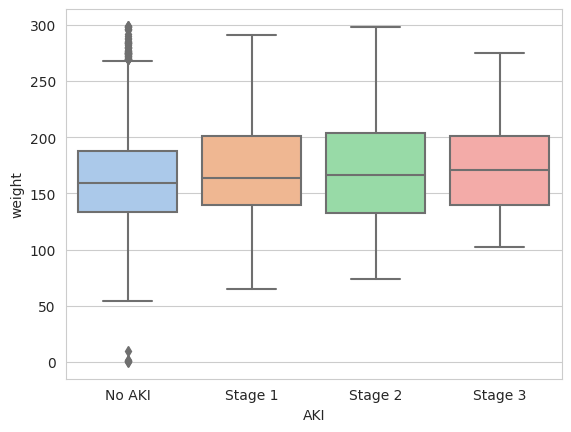

In [175]:
sns.set_style("whitegrid")
sns.boxplot(x = 'AKI', y = 'weight', palette='pastel', data = dataset_with_new_labels, order=['No AKI', 'Stage 1', 'Stage 2', 'Stage 3'])

Other statistics

In [183]:
dataset.age.astype(int).describe()

count    13128.000000
mean        63.552636
std         17.327521
min         18.000000
25%         53.000000
50%         65.000000
75%         77.000000
max        100.000000
Name: age, dtype: float64

In [185]:
dataset.gender.value_counts(normalize=True)*100

2    54.555149
1    45.444851
Name: gender, dtype: float64

In [191]:
print('ratio of patients aki_1: ', np.round(((dataset.aki_1==1).sum() / dataset.shape[0]), 2))
print('ratio of patients aki_1: ', np.round(((dataset.aki_2==1).sum() / dataset.shape[0]), 2))
print('ratio of patients aki_1: ', np.round(((dataset.aki_3==1).sum() / dataset.shape[0]), 2))

ratio of patients aki_1:  0.11
ratio of patients aki_1:  0.04
ratio of patients aki_1:  0.01


In [193]:
race_map

{1: 'WHITE',
 2: 'OTHER',
 3: 'BLACK/AFRICAN AMERICAN',
 4: 'UNABLE TO OBTAIN',
 5: 'UNKNOWN',
 6: 'WHITE  RUSSIAN',
 7: 'PORTUGUESE',
 8: 'WHITE  OTHER EUROPEAN',
 9: 'BLACK/CAPE VERDEAN',
 10: 'ASIAN',
 11: 'ASIAN  CHINESE',
 12: 'HISPANIC/LATINO  DOMINICAN',
 13: 'HISPANIC/LATINO  SALVADORAN',
 14: 'HISPANIC/LATINO  PUERTO RICAN',
 15: 'HISPANIC/LATINO  GUATEMALAN',
 16: 'ASIAN  SOUTH EAST ASIAN',
 17: 'WHITE  BRAZILIAN',
 18: 'HISPANIC OR LATINO',
 19: 'HISPANIC/LATINO  CENTRAL AMERICAN',
 20: 'BLACK/AFRICAN',
 21: 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 22: 'BLACK/CARIBBEAN ISLAND',
 23: 'HISPANIC/LATINO  MEXICAN',
 24: 'PATIENT DECLINED TO ANSWER',
 25: 'HISPANIC/LATINO  CUBAN',
 26: 'AMERICAN INDIAN/ALASKA NATIVE',
 27: 'MULTIPLE RACE/ETHNICITY',
 28: 'WHITE  EASTERN EUROPEAN',
 29: 'ASIAN  KOREAN',
 30: 'HISPANIC/LATINO  HONDURAN',
 31: 'ASIAN  ASIAN INDIAN',
 32: 'HISPANIC/LATINO  COLUMBIAN',
 33: 'SOUTH AMERICAN'}

In [192]:
dataset.race.value_counts(normalize=True)*100

1     64.251980
5     11.799208
3      6.192870
2      3.465874
4      1.691042
8      1.576782
10     1.401584
14     1.127361
11     1.013102
18     0.982633
12     0.731261
6      0.647471
24     0.601767
9      0.563681
7      0.487508
22     0.441804
20     0.388483
16     0.350396
17     0.297075
15     0.266606
31     0.236137
28     0.190433
26     0.175198
21     0.175198
33     0.144729
13     0.144729
32     0.114260
23     0.106642
29     0.099025
25     0.091408
27     0.091408
19     0.083790
30     0.068556
Name: race, dtype: float64

In [202]:
data_icustays[data_icustays.stay_id.isin(dataset.stay_id.unique())].los.describe()

count    13128.000000
mean         5.159648
std          5.266492
min          2.000116
25%          2.545009
50%          3.409716
75%          5.507526
max        110.232280
Name: los, dtype: float64

Overlap with lstm data

In [203]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles_2/dataset_lstm_icu.pkl', 'rb') as f:
    dataset_lstm = pickle.load(f)

In [206]:
stays_lstm = dataset_lstm.stay_id.unique()
print(len(stays_lstm))

14260


In [207]:
print(len(dataset.stay_id.unique()))

13128


In [208]:
def difference(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    #return lst3
    return lst3

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    #return lst3
    return lst3

In [210]:
overlap_stays = intersection(stays_lstm, dataset.stay_id.unique())
print(len(overlap_stays))

13110


In [211]:
difference_stays = difference(stays_lstm, dataset.stay_id.unique())
print('lstm dataset stays which are not in the xgb dataset: ', len(difference_stays))

lstm dataset stays which are not in the xgb dataset:  1150


In [212]:
difference_stays_rev = difference( dataset.stay_id.unique(), stays_lstm)
print('xgb dataset stays which are not in the lstm dataset: ', len(difference_stays_rev))

xgb dataset stays which are not in the lstm dataset:  18


# Normalization

In [12]:
columns_to_norm = dataset.columns[(pd.Series(dataset.columns).str.startswith('max') \
                    | (pd.Series(dataset.columns).str.startswith('min')))]

In [13]:
def iqr_capping(data_train, data_test, data_val, columns):
    new_data_train = data_train.copy()
    new_data_test = data_test.copy()
    new_data_val = data_val.copy()
    for col in columns:
        percentile25 = new_data_train[col].quantile(0.25)
        percentile75 = new_data_train[col].quantile(0.75)
        iqr = percentile75 - percentile25 
        upper_limit = percentile75 + 1.5 * iqr
        lower_limit = percentile25 - 1.5 * iqr
        new_data_train[col] = np.where(new_data_train[col] > upper_limit, upper_limit, \
                                np.where(new_data_train[col] < lower_limit, lower_limit,\
                                    new_data_train[col]))  
        new_data_test[col] = np.where(new_data_test[col] > upper_limit, upper_limit, \
                                np.where(new_data_test[col] < lower_limit, lower_limit,\
                                    new_data_test[col])) 
        new_data_val[col] = np.where(new_data_val[col] > upper_limit, upper_limit, \
                                np.where(new_data_val[col] < lower_limit, lower_limit,\
                                    new_data_val[col]))

    return new_data_train, new_data_test , new_data_val


In [14]:
train_data, test_data, val_data = iqr_capping(train_dataset, test_dataset, val_dataset, columns_to_norm)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

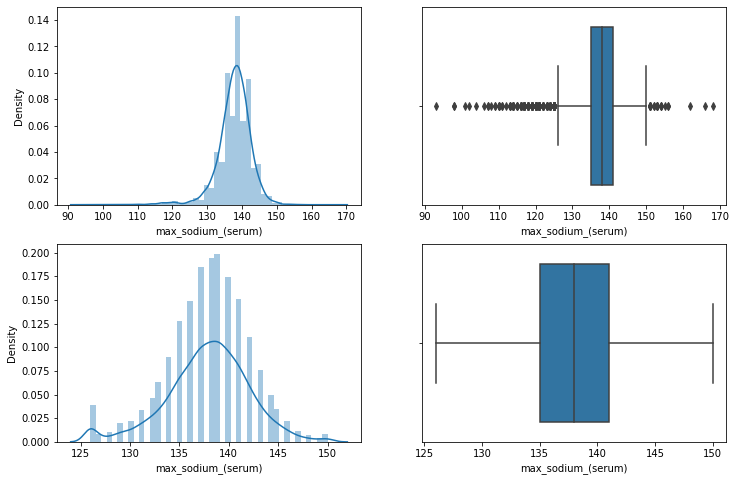

In [15]:
import seaborn as sns

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.distplot(train_dataset['max_sodium_(serum)'])
plt.subplot(2,2,2)
sns.boxplot(train_dataset['max_sodium_(serum)'])
plt.subplot(2,2,3)
sns.distplot(train_data['max_sodium_(serum)'])
plt.subplot(2,2,4)
sns.boxplot(train_data['max_sodium_(serum)'])
# plt.subplot(2,2,5)
# sns.distplot(train_dataset['max_urea_nitrogen'])
plt.show()

Missing value imputation

In [17]:
def impute_missing(data, columns_to_norm):
    df = data.copy()
    for column in columns_to_norm:
        df[column] = df[column].fillna(np.round(df[column].mean(), 2))

    return df

In [18]:
# missinf value imputation
columns_to_norm = dataset.columns[(pd.Series(dataset.columns).str.startswith('max') \
                    | (pd.Series(dataset.columns).str.startswith('min')))]

train_data = impute_missing(train_data, columns_to_norm)
val_data = impute_missing(val_data, columns_to_norm)
test_data = impute_missing(test_data, columns_to_norm)

# Make matricies

## Normal

In [75]:
train_data

,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),max_chloride_(serum),...,min_nbpm,max_nbpd,min_nbpd,output,race,gender,age,aki_1,aki_2,aki_3
0,10002155,28994087,31090461,21.4,60.0,109.4,51.0,99.0,136.00,106.00,...,76.00,25.00,64.00,3260.0,1,1,82,0,0,0
2,10002428,23473524,35479615,20.0,59.0,99.0,78.0,131.0,135.00,107.00,...,100.58,50.42,88.59,2255.0,1,1,81,0,0,0
3,10002428,28662225,33987268,20.0,59.0,99.0,78.0,131.0,133.00,98.00,...,92.00,19.00,90.00,805.0,1,1,81,1,1,0
5,10002428,28662225,38875437,20.0,59.0,99.0,78.0,131.0,144.00,110.00,...,127.00,30.00,116.00,1630.0,1,1,81,1,1,0
8,10002443,21329021,35044219,45.9,70.0,320.0,86.0,147.0,135.00,97.00,...,110.00,56.00,100.00,3450.0,1,2,53,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41462,15775655,21135699,34327707,NaN,NaN,NaN,NaN,NaN,139.71,103.44,...,85.00,57.00,76.00,2900.0,1,1,34,0,0,0
41463,15926317,24625959,39058424,NaN,NaN,NaN,NaN,NaN,139.71,103.44,...,99.00,49.00,94.00,720.0,1,1,50,0,0,0
41465,16045643,25632457,36737306,NaN,NaN,NaN,NaN,NaN,139.71,103.44,...,91.00,41.00,80.00,880.0,5,1,23,0,0,0
41467,16821470,23605278,32690638,NaN,NaN,NaN,NaN,NaN,139.71,103.44,...,108.00,48.00,90.00,NaN,1,2,71,0,0,0


In [19]:
X_data = train_data.drop(columns=['subject_id', 'stay_id', 'hadm_id', 'aki_1', 'aki_2', 'aki_3'])
y_data_1 = train_data.loc[:, ['aki_1']]
y_data_2 = train_data.loc[:, ['aki_2']]
y_data_3 = train_data.loc[:, ['aki_3']]

In [20]:
X_data.columns

Index(['bmi', 'height', 'weight', 'diastolic_bp', 'systolic_bp',
       'min_sodium_(serum)', 'max_chloride_(serum)', 'min_chloride_(serum)',
       'max_sodium_(serum)', 'max_potassium_(serum)', 'min_potassium_(serum)',
       'min_creatinine_(serum)', 'max_creatinine_(serum)', 'min_bun',
       'max_bun', 'max_hco3_(serum)', 'min_hco3_(serum)', 'max_anion_gap',
       'min_anion_gap', 'max_hematocrit_(serum)', 'min_hematocrit_(serum)',
       'min_glucose_(serum)', 'max_glucose_(serum)', 'min_hemoglobin',
       'max_hemoglobin', 'max_platelet_count', 'min_platelet_count', 'min_wbc',
       'max_wbc', 'min_magnesium', 'max_magnesium', 'min_phosphorous',
       'max_phosphorous', 'min_calcium_non-ionized', 'max_calcium_non-ionized',
       'min_prothrombin_time', 'max_prothrombin_time', 'min_inr', 'max_inr',
       'min_ptt', 'max_ptt', 'max_hr', 'min_hr', 'max_hr_alarm_-_low',
       'min_hr_alarm_-_low', 'max_hr_alarm_-_high', 'min_hr_alarm_-_high',
       'max_temperature_f', 'min_

In [21]:
X_train = np.array(X_data).astype('float32')
y_train_1 = np.array(y_data_1).astype('float32')
y_train_2 = np.array(y_data_2).astype('float32')
y_train_3 = np.array(y_data_3).astype('float32')
X_test = np.array(test_data.drop(columns=['subject_id', 'hadm_id','stay_id', 'aki_1', 'aki_2', 'aki_3'])).astype('float32')
y_test_1 =  np.array(test_data.loc[:, ['aki_1']].astype('float32'))
y_test_2 =  np.array(test_data.loc[:, ['aki_2']].astype('float32'))
y_test_3 =  np.array(test_data.loc[:, ['aki_3']].astype('float32'))

In [22]:
print('test', sum(y_test_1), len(y_test_1))
print('train', sum(y_train_1), len(y_train_1))

print('\ntest', sum(y_test_2), len(y_test_2))
print('train', sum(y_train_2), len(y_train_2))

print('\ntest', sum(y_test_3), len(y_test_3))
print('train', sum(y_train_3), len(y_train_3))

test [150.] 1328
train [1194.] 10487

test [56.] 1328
train [431.] 10487

test [15.] 1328
train [86.] 10487


## Oversampling

In [86]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

X_train = np.array(X_data).astype('float32')
y_train_1 = np.array(y_data_1).astype('float32').ravel()
y_train_2 = np.array(y_data_2).astype('float32').ravel()
y_train_3 = np.array(y_data_3).astype('float32').ravel()
X_test = np.array(test_data.drop(columns=['subject_id', 'hadm_id','stay_id','aki_1', 'aki_2', 'aki_3'])).astype('float32')
y_test_1 =  np.array(test_data.loc[:, ['aki_1']].astype('float32')).ravel()
y_test_2 =  np.array(test_data.loc[:, ['aki_2']].astype('float32')).ravel()
y_test_3 =  np.array(test_data.loc[:, ['aki_3']].astype('float32')).ravel()

In [87]:
print(X_train.shape)
print(X_test.shape)

(10487, 71)
(1328, 71)


In [88]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5)
oversample_20 = RandomOverSampler(sampling_strategy=0.2)
# fit and apply the transform
X_train_over_1, y_train_over_1 = oversample.fit_resample(X_train, y_train_1)
X_train_over_2, y_train_over_2 = oversample.fit_resample(X_train, y_train_2)
X_train_over_3, y_train_over_3 = oversample_20.fit_resample(X_train, y_train_3)

In [89]:
# summarize class distribution
print('Stage 1 and higher:\n' , 'before oversampling:',Counter(y_train_1))
print('after oversampling:',Counter(y_train_over_1))

print('\nStage 2 and higher:\n' , 'before oversampling:', Counter(y_train_2))
print('after oversampling:', Counter(y_train_over_2))

print('\nStage 3:\n' , 'before oversampling:',Counter(y_train_3))
print('after oversampling:',Counter(y_train_over_3))

Stage 1 and higher:
 before oversampling: Counter({0.0: 9293, 1.0: 1194})
after oversampling: Counter({0.0: 9293, 1.0: 4646})

Stage 2 and higher:
 before oversampling: Counter({0.0: 10056, 1.0: 431})
after oversampling: Counter({0.0: 10056, 1.0: 5028})

Stage 3:
 before oversampling: Counter({0.0: 10401, 1.0: 86})
after oversampling: Counter({0.0: 10401, 1.0: 2080})


## Downsampling

In [23]:
X_train = np.array(X_data).astype('float32')
y_train_1 = np.array(y_data_1).astype('float32').ravel()
y_train_2 = np.array(y_data_2).astype('float32').ravel()
y_train_3 = np.array(y_data_3).astype('float32').ravel()

X_test = np.array(test_data.drop(columns=['subject_id', 'hadm_id','stay_id','aki_1', 'aki_2', 'aki_3'])).astype('float32')
y_test_1 =  np.array(test_data.loc[:, ['aki_1']].astype('float32')).ravel()
y_test_2 =  np.array(test_data.loc[:, ['aki_2']].astype('float32')).ravel()
y_test_3 =  np.array(test_data.loc[:, ['aki_3']].astype('float32')).ravel()

In [24]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=0.4)
undersample_20 = RandomUnderSampler(sampling_strategy=0.2)
# fit and apply the transform
X_train_under_1, y_train_under_1 = undersample.fit_resample(X_train, y_train_1)
X_train_under_2, y_train_under_2 = undersample.fit_resample(X_train, y_train_2)
X_train_under_3, y_train_under_3 = undersample_20.fit_resample(X_train, y_train_3)

In [25]:
# summarize class distribution
print('Stage 1 and higher:\n' , 'before undersampling:',Counter(y_train_1))
print('after undersampling:',Counter(y_train_under_1))

print('\nStage 2 and higher:\n' , 'before undersampling:', Counter(y_train_2))
print('after undersampling:', Counter(y_train_under_2))

print('\nStage 3:\n' , 'before undersampling:',Counter(y_train_3))
print('after undersampling:',Counter(y_train_under_3))

Stage 1 and higher:
 before undersampling: Counter({0.0: 9293, 1.0: 1194})
after undersampling: Counter({0.0: 2985, 1.0: 1194})

Stage 2 and higher:
 before undersampling: Counter({0.0: 10056, 1.0: 431})
after undersampling: Counter({0.0: 1077, 1.0: 431})

Stage 3:
 before undersampling: Counter({0.0: 10401, 1.0: 86})
after undersampling: Counter({0.0: 430, 1.0: 86})


# CV

### max_depth and min_child_weight

In [103]:
dtrain = xgb.DMatrix(X_train, label=y_train_3)
dtest = xgb.DMatrix(X_test, label=y_test_3)

In [104]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,6,1)
    for min_child_weight in range(7,10,1)
]
gridsearch_params

[(3, 7), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 7), (5, 8), (5, 9)]

In [105]:
params = {
    'max_depth':3,
    'n_estimators':300,
    'min_child_weight':8,
    'colsample_bytree':0.8,
    'subsample':0.8,
    'eta':0.3,
    'seed':42
}

In [106]:
%%time
# Define initial best params and MAE
num_boost_round = 999
max_aucpr = float(0.0)
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=44,
        nfold=5,
        metrics={'aucpr'},
        early_stopping_rounds=10
    )
    # Update best RMSE
    mean_aucpr = cv_results['test-aucpr-mean'].max()
    boost_rounds = cv_results['test-aucpr-mean'].argmax()
    print("\tAUCPR {} for {} rounds".format(mean_aucpr, boost_rounds))
    if mean_aucpr> max_aucpr:
        max_aucpr = mean_aucpr
        best_params = (max_depth, min_child_weight)
print("Best params: {}, {}, AUCPR: {}".format(best_params[0], best_params[1], max_aucpr))

CV with max_depth=3, min_child_weight=7
[11:21:23] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:23] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:23] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost co

### subsample, colsample

In [107]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(8,11)]
    for colsample in [i/10. for i in range(8,11)]
]
gridsearch_params

[(0.8, 0.8),
 (0.8, 0.9),
 (0.8, 1.0),
 (0.9, 0.8),
 (0.9, 0.9),
 (0.9, 1.0),
 (1.0, 0.8),
 (1.0, 0.9),
 (1.0, 1.0)]

In [108]:
params = {
    'max_depth':3,
    'n_estimators':300,
    'min_child_weight':7,
    'colsample_bytree':0.8,
    'subsample':0.8,
    'eta':0.3,
    'seed':42
}

In [113]:
dtrain = xgb.DMatrix(y_train_3, label=y_train_3)
dtest = xgb.DMatrix(y_test_3, label=y_test_3)

In [114]:
%%time
# Define initial best params and MAE
num_boost_round = 999
max_aucpr = float(0.0)
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=44,
        nfold=5,
        metrics={'aucpr'},
        early_stopping_rounds=10
    )
    # Update best RMSE
    mean_aucpr = cv_results['test-aucpr-mean'].max()
    boost_rounds = cv_results['test-aucpr-mean'].argmax()
    print("\tAUCPR {} for {} rounds".format(mean_aucpr, boost_rounds))
    if mean_aucpr> max_aucpr:
        max_aucpr = mean_aucpr
        best_params = (subsample, colsample)
print("Best params: {}, {}, AUCPR: {}".format(best_params[0], best_params[1], max_aucpr))

CV with subsample=1.0, colsample=1.0
[11:27:54] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:27:55] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:27:55] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core,

# Parameters

In [ ]:
## Parameters found by CV
# AKI 1: max_depth =  3  , min_child_weight = 7, subsample = 1    , colsample = 1
# AKI 2: max_depth =  3  , min_child_weight = 7, subsample = 1    , colsample = 1
# AKI 3: max_depth =  3  , min_child_weight = 9, subsample = 1    , colsample = 1

In [26]:
# weights for data
scale_pos_weight_1 = np.round(len(y_train_1) / y_train_1.sum(), 2)
scale_pos_weight_2 = np.round(len(y_train_2) / y_train_2.sum(), 2)
scale_pos_weight_3 = np.round(len(y_train_3) / y_train_3.sum(), 2)
print(scale_pos_weight_1)
print(scale_pos_weight_2)
print(scale_pos_weight_3)

8.78
24.33
121.94


In [27]:
# weights for oversampled data
scale_pos_weight_1_overs = np.round(len(y_train_over_1) / y_train_over_1.sum(), 2)
scale_pos_weight_2_overs = np.round(len(y_train_over_2) / y_train_over_2.sum(), 2)
scale_pos_weight_3_overs = np.round(len(y_train_over_3) / y_train_over_3.sum(), 2)
print(scale_pos_weight_1_overs)
print(scale_pos_weight_2_overs)
print(scale_pos_weight_3_overs)

NameError: name 'y_train_over_1' is not defined

In [28]:
# weights for undersampling data
scale_pos_weight_1_unders = np.round(len(y_train_under_1) / y_train_under_1.sum(), 2)
scale_pos_weight_2_unders = np.round(len(y_train_under_2) / y_train_under_2.sum(), 2)
scale_pos_weight_3_unders = np.round(len(y_train_under_3) / y_train_under_3.sum(), 2)
print(scale_pos_weight_1_unders)
print(scale_pos_weight_2_unders)
print(scale_pos_weight_3_unders)

3.5
3.5
6.0


# AKI 1

## No class weights:

In [74]:
print(f'n features: {X_train.shape[1]}')

n features: 71


In [49]:
model_1 = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=43)
model_1.fit(
    X_train, 
    y_train_1, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=43,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=43,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [50]:
# evaluation
print(model_1.classes_)
probs_1 = model_1.predict_proba(X_test).T[1] # Predictions
predictions_1 = model_1.predict(X_test)
y_true_1 = y_test_1 # True values

[0. 1.]


Evaluation..
Best Threshold=0.23, F-Score=0.52
Accuracy: 0.88
F1:  0.51
Sensitivity:  0.55
Precision:  0.48
Specificity:  0.92
PR AUC:  0.53
ROC AUC:  0.74
Confusion matrix:
 [[1089   89]
 [  68   82]]
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1178
         1.0       0.48      0.55      0.51       150

    accuracy                           0.88      1328
   macro avg       0.71      0.74      0.72      1328
weighted avg       0.89      0.88      0.89      1328

Precision 20.0% , Sensitivity 0.93 
Precision 25.0% , Sensitivity 0.86 
Precision 33.0% , Sensitivity 0.74 
Precision 40.0% , Sensitivity 0.67 
Precision 50.0% , Sensitivity 0.55 
Precision 60.0% , Sensitivity 0.36 
Precision 74.0% , Sensitivity 0.23 


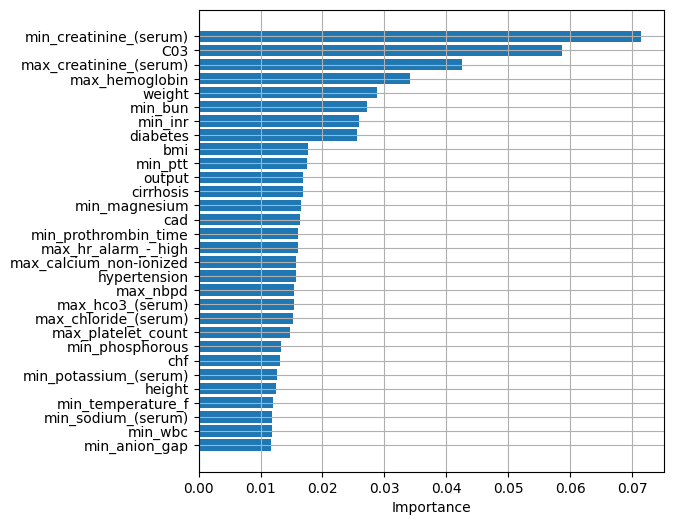

{'min_creatinine_(serum)': 0.07150381,
 'C03': 0.058650568,
 'max_creatinine_(serum)': 0.042502157,
 'max_hemoglobin': 0.034108836,
 'weight': 0.02884097,
 'min_bun': 0.027141541,
 'min_inr': 0.025899097,
 'diabetes': 0.025651762,
 'bmi': 0.017704364,
 'min_ptt': 0.017489271,
 'output': 0.01680262,
 'cirrhosis': 0.01679186,
 'min_magnesium': 0.016535832,
 'cad': 0.01645189,
 'min_prothrombin_time': 0.01601034,
 'max_hr_alarm_-_high': 0.01599871,
 'max_calcium_non-ionized': 0.015794637,
 'hypertension': 0.015678253,
 'max_nbpd': 0.015447664,
 'max_hco3_(serum)': 0.01535511,
 'max_chloride_(serum)': 0.0153147625,
 'max_platelet_count': 0.014821694,
 'min_phosphorous': 0.013313291,
 'chf': 0.013211312,
 'min_potassium_(serum)': 0.012655599,
 'height': 0.0125643965,
 'min_temperature_f': 0.011960657,
 'min_sodium_(serum)': 0.011903802,
 'min_wbc': 0.011807206,
 'min_anion_gap': 0.011629809}

In [67]:
# with diags and meds
evaluate(y_true_1, probs_1)
plot_importances(X_data, model_1, top=30)

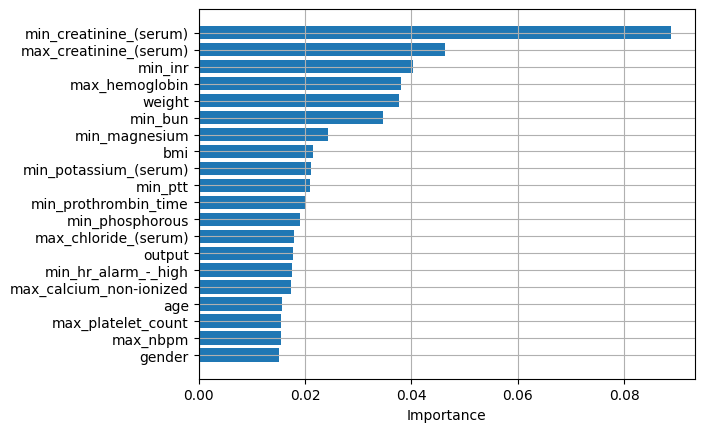

{'min_creatinine_(serum)': 0.088780954,
 'max_creatinine_(serum)': 0.046383597,
 'min_inr': 0.040270533,
 'max_hemoglobin': 0.03802954,
 'weight': 0.03767256,
 'min_bun': 0.03464956,
 'min_magnesium': 0.024335902,
 'bmi': 0.021438057,
 'min_potassium_(serum)': 0.021184973,
 'min_ptt': 0.020887638,
 'min_prothrombin_time': 0.020130204,
 'min_phosphorous': 0.019017361,
 'max_chloride_(serum)': 0.017837152,
 'output': 0.017819706,
 'min_hr_alarm_-_high': 0.017502842,
 'max_calcium_non-ionized': 0.017379858,
 'age': 0.015610955,
 'max_platelet_count': 0.015517847,
 'max_nbpm': 0.015483102,
 'gender': 0.01508996}

In [183]:
plot_importances(X_data, model_1, top=20)

### Oversampling

In [90]:
model_1_overs = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)
model_1_overs.fit(
    X_train_over_1, 
    y_train_over_1, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [91]:
# evaluation
print(model_1_overs.classes_)
probs_1_overs = model_1_overs.predict_proba(X_test).T[1] # Predictions
predictions_1_overs = model_1_overs.predict(X_test)
y_true_1 = y_test_1 # True values

[0. 1.]


Evaluation..
Best Threshold=0.32, F-Score=0.54
Accuracy: 0.88
F1:  0.53
Sensitivity:  0.59
Precision:  0.48
Specificity:  0.92
PR AUC:  0.54
ROC AUC:  0.75
Confusion matrix:
 [[1084   94]
 [  62   88]]
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93      1178
         1.0       0.48      0.59      0.53       150

    accuracy                           0.88      1328
   macro avg       0.71      0.75      0.73      1328
weighted avg       0.89      0.88      0.89      1328

Precision 20.0% , Sensitivity 0.94 
Precision 25.0% , Sensitivity 0.87 
Precision 33.0% , Sensitivity 0.77 
Precision 40.0% , Sensitivity 0.68 
Precision 50.0% , Sensitivity 0.57 
Precision 60.0% , Sensitivity 0.48 
Precision 74.0% , Sensitivity 0.17 


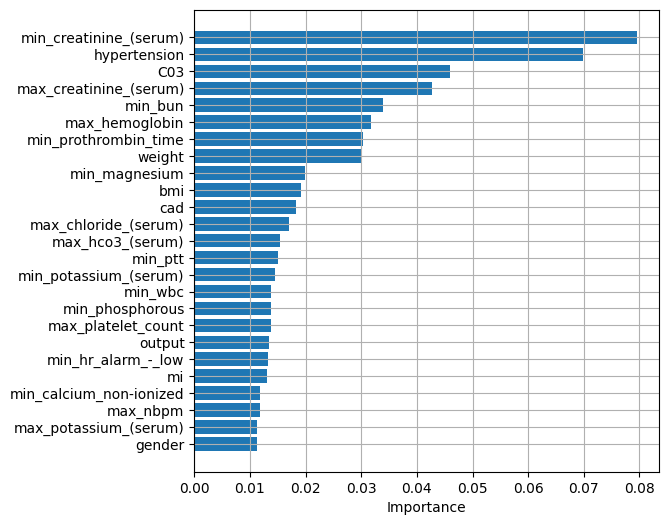

{'min_creatinine_(serum)': 0.07958857,
 'hypertension': 0.06979376,
 'C03': 0.045865536,
 'max_creatinine_(serum)': 0.04266405,
 'min_bun': 0.033830855,
 'max_hemoglobin': 0.03169015,
 'min_prothrombin_time': 0.030363489,
 'weight': 0.030104471,
 'min_magnesium': 0.019897604,
 'bmi': 0.019208308,
 'cad': 0.018285908,
 'max_chloride_(serum)': 0.017022759,
 'max_hco3_(serum)': 0.015412166,
 'min_ptt': 0.0150074335,
 'min_potassium_(serum)': 0.014453816,
 'min_wbc': 0.0138620725,
 'min_phosphorous': 0.013793778,
 'max_platelet_count': 0.013732477,
 'output': 0.013428421,
 'min_hr_alarm_-_low': 0.013186004,
 'mi': 0.013137081,
 'min_calcium_non-ionized': 0.011870452,
 'max_nbpm': 0.011818016,
 'max_potassium_(serum)': 0.011282432,
 'gender': 0.011195601}

In [92]:
evaluate(y_true_1, probs_1_overs)
plot_importances(X_data, model_1_overs, top=25)

In [280]:
evaluate(y_true_1, probs_1_overs)

Evaluation..
Best Threshold=0.28, F-Score=0.51
Accuracy: 0.87
F1:  0.51
Sensitivity:  0.61
Precision:  0.44
Specificity:  0.9
PR AUC:  0.52
ROC AUC:  0.75
Confusion matrix:
 [[1063  115]
 [  59   91]]
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      1178
         1.0       0.44      0.61      0.51       150

    accuracy                           0.87      1328
   macro avg       0.69      0.75      0.72      1328
weighted avg       0.89      0.87      0.88      1328

Precision 20.0% , Sensitivity 0.91 
Precision 25.0% , Sensitivity 0.89 
Precision 33.0% , Sensitivity 0.75 
Precision 40.0% , Sensitivity 0.62 
Precision 50.0% , Sensitivity 0.5 
Precision 60.0% , Sensitivity 0.36 
Precision 75.0% , Sensitivity 0.22 


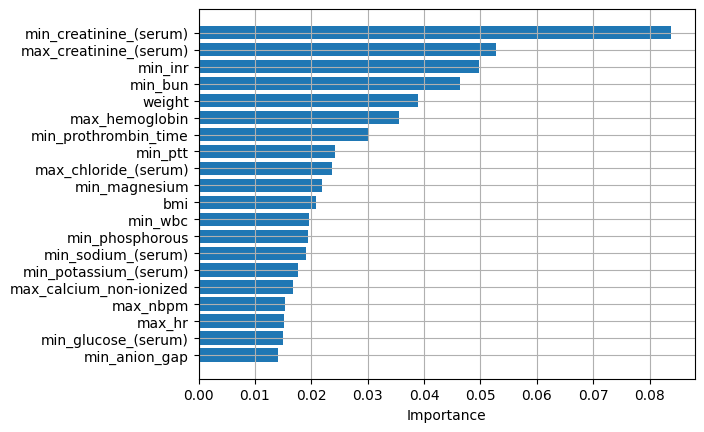

{'min_creatinine_(serum)': 0.08380582,
 'max_creatinine_(serum)': 0.052818563,
 'min_inr': 0.049784295,
 'min_bun': 0.04636082,
 'weight': 0.038941592,
 'max_hemoglobin': 0.035520963,
 'min_prothrombin_time': 0.030231316,
 'min_ptt': 0.024171129,
 'max_chloride_(serum)': 0.023607876,
 'min_magnesium': 0.021863336,
 'bmi': 0.020853542,
 'min_wbc': 0.019604642,
 'min_phosphorous': 0.019390598,
 'min_sodium_(serum)': 0.019043952,
 'min_potassium_(serum)': 0.017559605,
 'max_calcium_non-ionized': 0.016699363,
 'max_nbpm': 0.015299869,
 'max_hr': 0.0151519105,
 'min_glucose_(serum)': 0.0149444975,
 'min_anion_gap': 0.014033226}

In [277]:
plot_importances(X_data, model_1_overs, top=20)

### Undersampling

In [116]:
model_1_unders = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)
model_1_unders.fit(
    X_train_under_1, 
    y_train_under_1, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [117]:
# evaluation
print(model_1_unders.classes_)
probs_1_unders = model_1_unders.predict_proba(X_test).T[1] # Predictions
predictions_1_unders = model_1_unders.predict(X_test)
y_true_1 = y_test_1 # True values

[0. 1.]


Evaluation..
Best Threshold=0.25, F-Score=0.49
Accuracy: 0.83
F1:  0.48
Sensitivity:  0.71
Precision:  0.37
Specificity:  0.84
PR AUC:  0.49
ROC AUC:  0.78
Confusion matrix:
 [[992 186]
 [ 43 107]]
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      1178
         1.0       0.37      0.71      0.48       150

    accuracy                           0.83      1328
   macro avg       0.66      0.78      0.69      1328
weighted avg       0.89      0.83      0.85      1328

Precision 20.0% , Sensitivity 0.94 
Precision 25.0% , Sensitivity 0.85 
Precision 33.0% , Sensitivity 0.73 
Precision 40.0% , Sensitivity 0.59 
Precision 50.0% , Sensitivity 0.37 
Precision 60.0% , Sensitivity 0.29 
Precision 75.0% , Sensitivity 0.2 


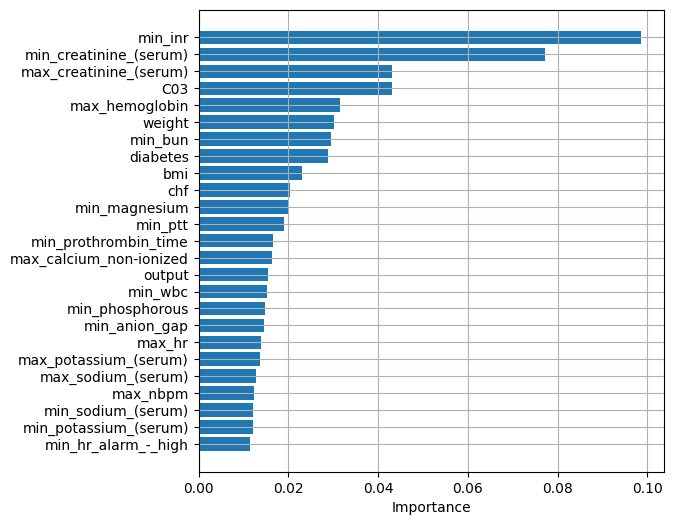

{'min_inr': 0.09866468,
 'min_creatinine_(serum)': 0.077088155,
 'max_creatinine_(serum)': 0.043170664,
 'C03': 0.043124944,
 'max_hemoglobin': 0.03153775,
 'weight': 0.030079016,
 'min_bun': 0.029454367,
 'diabetes': 0.028766701,
 'bmi': 0.023049226,
 'chf': 0.020403825,
 'min_magnesium': 0.01995848,
 'min_ptt': 0.018960368,
 'min_prothrombin_time': 0.016592711,
 'max_calcium_non-ionized': 0.016244333,
 'output': 0.015428595,
 'min_wbc': 0.015158898,
 'min_phosphorous': 0.014902437,
 'min_anion_gap': 0.014608199,
 'max_hr': 0.013834371,
 'max_potassium_(serum)': 0.013648766,
 'max_sodium_(serum)': 0.012725711,
 'max_nbpm': 0.012360077,
 'min_sodium_(serum)': 0.012107088,
 'min_potassium_(serum)': 0.012087114,
 'min_hr_alarm_-_high': 0.011370549}

In [118]:
evaluate(y_true_1, probs_1_unders)
plot_importances(X_data, model_1_unders, top=25)

In [354]:
evaluate(y_true_1, probs_1_unders)

Evaluation..
Best Threshold=0.44, F-Score=0.52
Accuracy: 0.85
F1:  0.51
Sensitivity:  0.67
Precision:  0.41
Specificity:  0.88
PR AUC:  0.55
ROC AUC:  0.78
Confusion matrix:
 [[1034  144]
 [  49  101]]
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      1178
         1.0       0.41      0.67      0.51       150

    accuracy                           0.85      1328
   macro avg       0.68      0.78      0.71      1328
weighted avg       0.89      0.85      0.87      1328

Precision 20.0% , Sensitivity 0.94 
Precision 25.0% , Sensitivity 0.92 
Precision 33.0% , Sensitivity 0.76 
Precision 40.0% , Sensitivity 0.71 
Precision 50.0% , Sensitivity 0.51 
Precision 60.0% , Sensitivity 0.33 
Precision 75.0% , Sensitivity 0.27 


## With Class weights:

In [29]:
model_1_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_1,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=43)

model_1_weights.fit(
    X_train, 
    y_train_1, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=43,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8.78, seed=43,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [76]:
# evaluation
print(model_1_weights.classes_)
probs_1_weights = model_1_weights.predict_proba(X_test).T[1] # Predictions
predictions_1_weights = model_1_weights.predict(X_test)
y_true_1 = y_test_1 # True values

[0. 1.]


Evaluation..
Best Threshold=0.20, F-Score=0.50
Accuracy: 0.83
F1:  0.49
Sensitivity:  0.71
Precision:  0.37
Specificity:  0.85
PR AUC:  0.54
ROC AUC:  0.78
Confusion matrix:
 [[999 179]
 [ 44 106]]
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      1178
         1.0       0.37      0.71      0.49       150

    accuracy                           0.83      1328
   macro avg       0.66      0.78      0.69      1328
weighted avg       0.89      0.83      0.85      1328

Precision 20.0% , Sensitivity 0.93 
Precision 25.0% , Sensitivity 0.87 
Precision 33.0% , Sensitivity 0.75 
Precision 40.0% , Sensitivity 0.67 
Precision 50.0% , Sensitivity 0.46 
Precision 60.0% , Sensitivity 0.42 
Precision 75.0% , Sensitivity 0.22 


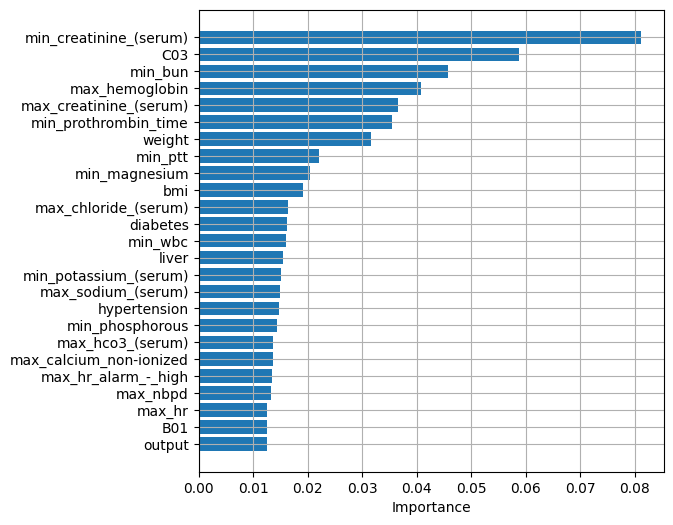

{'min_creatinine_(serum)': 0.08119258,
 'C03': 0.058706287,
 'min_bun': 0.045800578,
 'max_hemoglobin': 0.04081865,
 'max_creatinine_(serum)': 0.036548372,
 'min_prothrombin_time': 0.035533447,
 'weight': 0.031575006,
 'min_ptt': 0.022156727,
 'min_magnesium': 0.0204063,
 'bmi': 0.019114906,
 'max_chloride_(serum)': 0.016334642,
 'diabetes': 0.01621064,
 'min_wbc': 0.016019218,
 'liver': 0.015502628,
 'min_potassium_(serum)': 0.015081795,
 'max_sodium_(serum)': 0.014942397,
 'hypertension': 0.01475047,
 'min_phosphorous': 0.014417254,
 'max_hco3_(serum)': 0.013653456,
 'max_calcium_non-ionized': 0.013649158,
 'max_hr_alarm_-_high': 0.013408816,
 'max_nbpd': 0.01324424,
 'max_hr': 0.012572292,
 'B01': 0.012569326,
 'output': 0.012461836}

In [77]:
evaluate(y_true_1, probs_1_weights)
plot_importances(X_data, model_1_weights, top=25)

In [232]:
evaluate(y_true_1, probs_1_weights)

Evaluation..
Best Threshold=0.32, F-Score=0.47
Accuracy: 0.84
F1:  0.46
Sensitivity:  0.59
Precision:  0.38
Specificity:  0.88
PR AUC:  0.5
ROC AUC:  0.74
Confusion matrix:
 [[1033  145]
 [  61   89]]
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1178
         1.0       0.38      0.59      0.46       150

    accuracy                           0.84      1328
   macro avg       0.66      0.74      0.69      1328
weighted avg       0.88      0.84      0.86      1328

Precision 20.0% , Sensitivity 0.95 
Precision 25.0% , Sensitivity 0.86 
Precision 33.0% , Sensitivity 0.71 
Precision 40.0% , Sensitivity 0.57 
Precision 50.0% , Sensitivity 0.41 
Precision 60.0% , Sensitivity 0.37 
Precision 75.0% , Sensitivity 0.12 


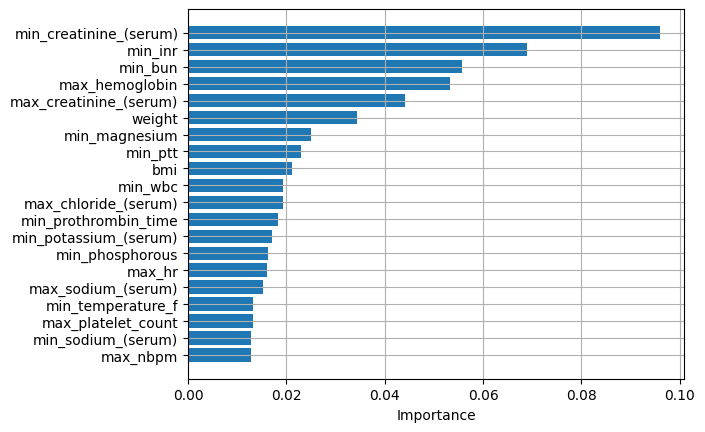

{'min_creatinine_(serum)': 0.09610039,
 'min_inr': 0.0689855,
 'min_bun': 0.055673935,
 'max_hemoglobin': 0.053208012,
 'max_creatinine_(serum)': 0.044200342,
 'weight': 0.03445499,
 'min_magnesium': 0.024994852,
 'min_ptt': 0.022959324,
 'bmi': 0.021090614,
 'min_wbc': 0.019343985,
 'max_chloride_(serum)': 0.019238444,
 'min_prothrombin_time': 0.018337581,
 'min_potassium_(serum)': 0.017135607,
 'min_phosphorous': 0.01630195,
 'max_hr': 0.016007494,
 'max_sodium_(serum)': 0.015339155,
 'min_temperature_f': 0.013290216,
 'max_platelet_count': 0.013151021,
 'min_sodium_(serum)': 0.012862359,
 'max_nbpm': 0.0127917165}

In [233]:
plot_importances(X_data, model_1_weights, top=20)

### Oversampling

In [101]:
model_1_overs_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_1_overs,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)

model_1_overs_weights.fit(
    X_train_over_1, 
    y_train_over_1, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)


/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.0, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [102]:
# evaluation
print(model_1_overs_weights.classes_)
probs_1_overs_weights = model_1_overs_weights.predict_proba(X_test).T[1] # Predictions
predictions_1_overs_weights = model_1_overs_weights.predict(X_test)
y_true_1 = y_test_1 # True values

[0. 1.]


Evaluation..
Best Threshold=0.56, F-Score=0.56
Accuracy: 0.9
F1:  0.55
Sensitivity:  0.54
Precision:  0.57
Specificity:  0.95
PR AUC:  0.56
ROC AUC:  0.74
Confusion matrix:
 [[1116   62]
 [  69   81]]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      1178
         1.0       0.57      0.54      0.55       150

    accuracy                           0.90      1328
   macro avg       0.75      0.74      0.75      1328
weighted avg       0.90      0.90      0.90      1328

Precision 20.0% , Sensitivity 0.94 
Precision 25.0% , Sensitivity 0.88 
Precision 33.0% , Sensitivity 0.75 
Precision 40.0% , Sensitivity 0.64 
Precision 50.0% , Sensitivity 0.6 
Precision 60.0% , Sensitivity 0.51 
Precision 75.0% , Sensitivity 0.27 


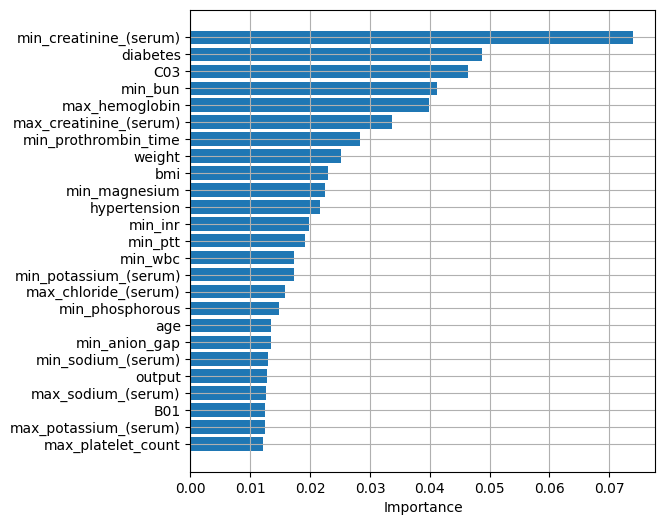

{'min_creatinine_(serum)': 0.074011914,
 'diabetes': 0.04871958,
 'C03': 0.0464166,
 'min_bun': 0.04113989,
 'max_hemoglobin': 0.039838165,
 'max_creatinine_(serum)': 0.033680275,
 'min_prothrombin_time': 0.028274795,
 'weight': 0.025188,
 'bmi': 0.022996824,
 'min_magnesium': 0.022400167,
 'hypertension': 0.021641342,
 'min_inr': 0.019800855,
 'min_ptt': 0.0191839,
 'min_wbc': 0.01733835,
 'min_potassium_(serum)': 0.017333249,
 'max_chloride_(serum)': 0.015816709,
 'min_phosphorous': 0.014854558,
 'age': 0.013514016,
 'min_anion_gap': 0.013487008,
 'min_sodium_(serum)': 0.013000569,
 'output': 0.012835615,
 'max_sodium_(serum)': 0.012595247,
 'B01': 0.012475807,
 'max_potassium_(serum)': 0.012421831,
 'max_platelet_count': 0.0121832695}

In [103]:
evaluate(y_true_1, probs_1_overs_weights)
plot_importances(X_data, model_1_overs_weights, top=25)

In [314]:
evaluate(y_true_1, probs_1_overs_weights)

Evaluation..
Best Threshold=0.38, F-Score=0.50
Accuracy: 0.86
F1:  0.49
Sensitivity:  0.59
Precision:  0.42
Specificity:  0.9
PR AUC:  0.53
ROC AUC:  0.74
Confusion matrix:
 [[1058  120]
 [  62   88]]
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1178
         1.0       0.42      0.59      0.49       150

    accuracy                           0.86      1328
   macro avg       0.68      0.74      0.71      1328
weighted avg       0.89      0.86      0.87      1328

Precision 20.0% , Sensitivity 0.94 
Precision 25.0% , Sensitivity 0.91 
Precision 33.0% , Sensitivity 0.75 
Precision 40.0% , Sensitivity 0.61 
Precision 50.0% , Sensitivity 0.41 
Precision 60.0% , Sensitivity 0.35 
Precision 75.0% , Sensitivity 0.28 


### Undersampling

In [30]:
scale_pos_weight_1_unders

3.5

In [31]:
model_1_unders_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_1_unders,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)

model_1_unders_weights.fit(
    X_train_under_1, 
    y_train_under_1, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [32]:
# evaluation
print(model_1_unders_weights.classes_)
probs_1_unders_weights = model_1_unders_weights.predict_proba(X_test).T[1] # Predictions
predictions_1_unders_weights = model_1_unders_weights.predict(X_test)
y_true_1 = y_test_1 # True values

[0. 1.]


Evaluation..
Best Threshold=0.68, F-Score=0.51
Accuracy: 0.87
F1:  0.5
Sensitivity:  0.57
Precision:  0.44
Specificity:  0.91
PR AUC:  0.53
ROC AUC:  0.74
Confusion matrix:
 [[1070  108]
 [  64   86]]
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      1178
         1.0       0.44      0.57      0.50       150

    accuracy                           0.87      1328
   macro avg       0.69      0.74      0.71      1328
weighted avg       0.89      0.87      0.88      1328

Precision 20.0% , Sensitivity 0.97 
Precision 25.0% , Sensitivity 0.91 
Precision 33.0% , Sensitivity 0.77 
Precision 40.0% , Sensitivity 0.65 
Precision 50.0% , Sensitivity 0.47 
Precision 60.0% , Sensitivity 0.39 
Precision 75.0% , Sensitivity 0.25 


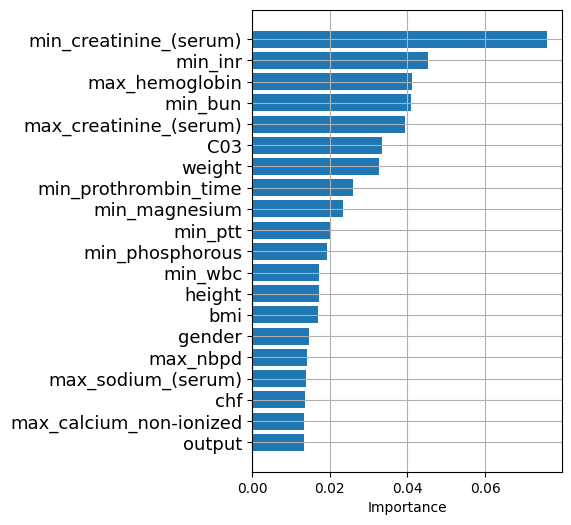

{'min_creatinine_(serum)': 0.075980805,
 'min_inr': 0.045196857,
 'max_hemoglobin': 0.041261636,
 'min_bun': 0.040862713,
 'max_creatinine_(serum)': 0.039407004,
 'C03': 0.03357739,
 'weight': 0.03256391,
 'min_prothrombin_time': 0.02589952,
 'min_magnesium': 0.023320986,
 'min_ptt': 0.020027442,
 'min_phosphorous': 0.019259894,
 'min_wbc': 0.017206663,
 'height': 0.017205717,
 'bmi': 0.01689204,
 'gender': 0.014791327,
 'max_nbpd': 0.014107711,
 'max_sodium_(serum)': 0.013813756,
 'chf': 0.013678857,
 'max_calcium_non-ionized': 0.013474359,
 'output': 0.013365442}

In [53]:
evaluate(y_true_1, probs_1_unders_weights)
plot_importances(X_data, model_1_unders_weights, top=20)

In [375]:
evaluate(y_true_1, probs_1_unders_weights)

Evaluation..
Best Threshold=0.76, F-Score=0.51
Accuracy: 0.88
F1:  0.51
Sensitivity:  0.55
Precision:  0.47
Specificity:  0.92
PR AUC:  0.55
ROC AUC:  0.74
Confusion matrix:
 [[1084   94]
 [  67   83]]
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1178
         1.0       0.47      0.55      0.51       150

    accuracy                           0.88      1328
   macro avg       0.71      0.74      0.72      1328
weighted avg       0.89      0.88      0.88      1328

Precision 20.0% , Sensitivity 0.96 
Precision 25.0% , Sensitivity 0.91 
Precision 33.0% , Sensitivity 0.77 
Precision 40.0% , Sensitivity 0.66 
Precision 50.0% , Sensitivity 0.5 
Precision 60.0% , Sensitivity 0.39 
Precision 75.0% , Sensitivity 0.28 


# AKI 2

## No class weights:

In [68]:
model_2 = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)

model_2.fit(
    X_train, 
    y_train_2, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [69]:
# evaluation
print(model_2.classes_)
probs_2 = model_2.predict_proba(X_test).T[1] # Predictions
predictions_2 = model_2.predict(X_test)
y_true_2 = y_test_2 # True values

[0. 1.]


Evaluation..
Best Threshold=0.05, F-Score=0.35
Accuracy: 0.92
F1:  0.34
Sensitivity:  0.5
Precision:  0.25
Specificity:  0.94
PR AUC:  0.27
ROC AUC:  0.72
Confusion matrix:
 [[1190   82]
 [  28   28]]
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      1272
         1.0       0.25      0.50      0.34        56

    accuracy                           0.92      1328
   macro avg       0.62      0.72      0.65      1328
weighted avg       0.95      0.92      0.93      1328

Precision 20.0% , Sensitivity 0.7 
Precision 25.0% , Sensitivity 0.52 
Precision 33.0% , Sensitivity 0.16 
Precision 40.0% , Sensitivity 0.14 
Precision 50.0% , Sensitivity 0.11 
Precision 60.0% , Sensitivity 0.11 
Precision 75.0% , Sensitivity 0.11 


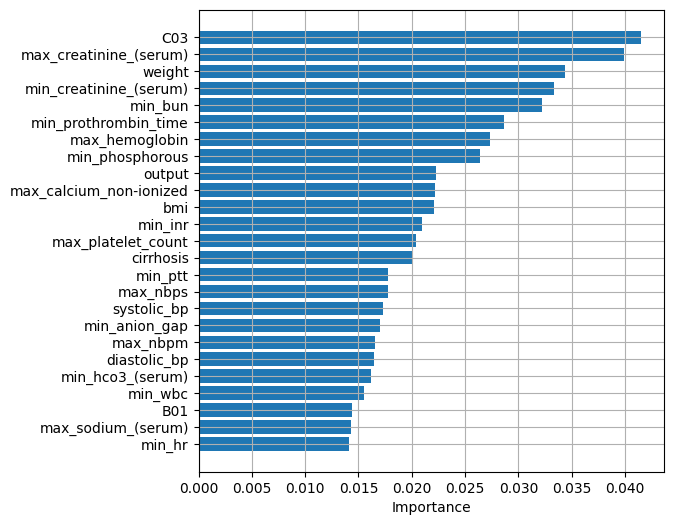

{'C03': 0.041551955,
 'max_creatinine_(serum)': 0.03988571,
 'weight': 0.034424067,
 'min_creatinine_(serum)': 0.03333632,
 'min_bun': 0.03224545,
 'min_prothrombin_time': 0.028658103,
 'max_hemoglobin': 0.027371077,
 'min_phosphorous': 0.02642589,
 'output': 0.022258162,
 'max_calcium_non-ionized': 0.022188654,
 'bmi': 0.022067167,
 'min_inr': 0.02095545,
 'max_platelet_count': 0.020427486,
 'cirrhosis': 0.02009073,
 'min_ptt': 0.017809136,
 'max_nbps': 0.017800624,
 'systolic_bp': 0.017294178,
 'min_anion_gap': 0.016987551,
 'max_nbpm': 0.016552176,
 'diastolic_bp': 0.016499784,
 'min_hco3_(serum)': 0.01616863,
 'min_wbc': 0.015557188,
 'B01': 0.014378731,
 'max_sodium_(serum)': 0.014286115,
 'min_hr': 0.014154049}

In [70]:
# diags meds
evaluate(y_true_2, probs_2)
plot_importances(X_data, model_2, top=25)

In [207]:
evaluate(y_true_2, probs_2)

Evaluation..
Best Threshold=0.01, F-Score=0.31
Accuracy: 0.84
F1:  0.27
Sensitivity:  0.71
Precision:  0.17
Specificity:  0.85
PR AUC:  0.22
ROC AUC:  0.78
Confusion matrix:
 [[1077  195]
 [  16   40]]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      1272
         1.0       0.17      0.71      0.27        56

    accuracy                           0.84      1328
   macro avg       0.58      0.78      0.59      1328
weighted avg       0.95      0.84      0.88      1328

Precision 20.0% , Sensitivity 0.68 
Precision 25.0% , Sensitivity 0.38 
Precision 33.0% , Sensitivity 0.27 
Precision 38.0% , Sensitivity 0.05 
Precision 50.0% , Sensitivity 0.02 
Precision 50.0% , Sensitivity 0.02 
Precision 50.0% , Sensitivity 0.02 


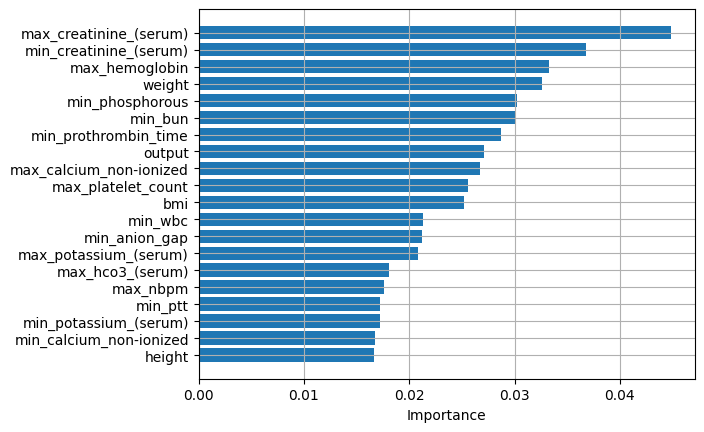

{'max_creatinine_(serum)': 0.044855252,
 'min_creatinine_(serum)': 0.036812123,
 'max_hemoglobin': 0.03322807,
 'weight': 0.032631177,
 'min_phosphorous': 0.030262353,
 'min_bun': 0.030092925,
 'min_prothrombin_time': 0.028720446,
 'output': 0.027083477,
 'max_calcium_non-ionized': 0.026735596,
 'max_platelet_count': 0.025549011,
 'bmi': 0.02516705,
 'min_wbc': 0.021265354,
 'min_anion_gap': 0.021173371,
 'max_potassium_(serum)': 0.02088035,
 'max_hco3_(serum)': 0.018108906,
 'max_nbpm': 0.017566519,
 'min_ptt': 0.017190052,
 'min_potassium_(serum)': 0.01718386,
 'min_calcium_non-ionized': 0.016790917,
 'height': 0.016655803}

In [201]:
plot_importances(X_data, model_2, top=20)

### Oversampling

In [93]:
model_2_overs = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)
model_2_overs.fit(
    X_train_over_2, 
    y_train_over_2, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [94]:
# evaluation
print(model_2_overs.classes_)
probs_2_overs = model_2_overs.predict_proba(X_test).T[1] # Predictions
predictions_2_overs = model_2_overs.predict(X_test)
y_true_2 = y_test_2 # True values

[0. 1.]


Evaluation..
Best Threshold=0.02, F-Score=0.31
Accuracy: 0.85
F1:  0.3
Sensitivity:  0.79
Precision:  0.19
Specificity:  0.85
PR AUC:  0.21
ROC AUC:  0.82
Confusion matrix:
 [[1080  192]
 [  12   44]]
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      1272
         1.0       0.19      0.79      0.30        56

    accuracy                           0.85      1328
   macro avg       0.59      0.82      0.61      1328
weighted avg       0.96      0.85      0.89      1328

Precision 20.0% , Sensitivity 0.7 
Precision 25.0% , Sensitivity 0.23 
Precision 33.0% , Sensitivity 0.09 
Precision 40.0% , Sensitivity 0.07 
Precision 50.0% , Sensitivity 0.07 
Precision 60.0% , Sensitivity 0.05 
Precision 67.0% , Sensitivity 0.07 


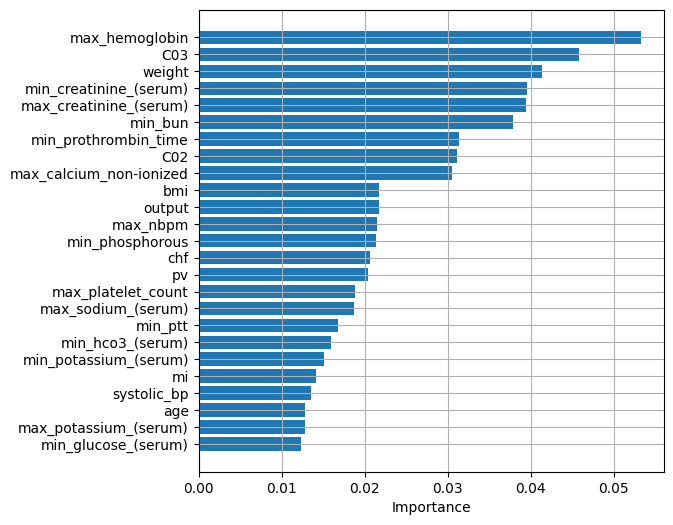

{'max_hemoglobin': 0.053339865,
 'C03': 0.045808647,
 'weight': 0.041328505,
 'min_creatinine_(serum)': 0.039515715,
 'max_creatinine_(serum)': 0.03946325,
 'min_bun': 0.037904117,
 'min_prothrombin_time': 0.0313914,
 'C02': 0.031071717,
 'max_calcium_non-ionized': 0.030485377,
 'bmi': 0.021732725,
 'output': 0.021671467,
 'max_nbpm': 0.021454925,
 'min_phosphorous': 0.021378376,
 'chf': 0.020683795,
 'pv': 0.020427184,
 'max_platelet_count': 0.01885565,
 'max_sodium_(serum)': 0.018765967,
 'min_ptt': 0.016784074,
 'min_hco3_(serum)': 0.015928598,
 'min_potassium_(serum)': 0.015116069,
 'mi': 0.01409528,
 'systolic_bp': 0.013526414,
 'age': 0.0128622465,
 'max_potassium_(serum)': 0.012861259,
 'min_glucose_(serum)': 0.012331163}

In [95]:
evaluate(y_true_2, probs_2_overs)
plot_importances(X_data, model_2_overs, top=25)

In [289]:
evaluate(y_true_2, probs_2_overs)

Evaluation..
Best Threshold=0.05, F-Score=0.28
Accuracy: 0.89
F1:  0.26
Sensitivity:  0.48
Precision:  0.18
Specificity:  0.9
PR AUC:  0.19
ROC AUC:  0.69
Confusion matrix:
 [[1151  121]
 [  29   27]]
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      1272
         1.0       0.18      0.48      0.26        56

    accuracy                           0.89      1328
   macro avg       0.58      0.69      0.60      1328
weighted avg       0.94      0.89      0.91      1328

Precision 20.0% , Sensitivity 0.48 
Precision 25.0% , Sensitivity 0.23 
Precision 33.0% , Sensitivity 0.14 
Precision 40.0% , Sensitivity 0.11 
Precision 50.0% , Sensitivity 0.09 
Precision 50.0% , Sensitivity 0.09 
Precision 50.0% , Sensitivity 0.09 


### Undersampling

In [119]:
model_2_unders = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)
model_2_unders.fit(
    X_train_under_2, 
    y_train_under_2, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [120]:
# evaluation
print(model_2_unders.classes_)
probs_2_unders = model_2_unders.predict_proba(X_test).T[1] # Predictions
predictions_2_unders = model_2_unders.predict(X_test)
y_true_2 = y_test_2 # True values

[0. 1.]


Evaluation..
Best Threshold=0.70, F-Score=0.37
Accuracy: 0.91
F1:  0.37
Sensitivity:  0.59
Precision:  0.27
Specificity:  0.93
PR AUC:  0.25
ROC AUC:  0.76
Confusion matrix:
 [[1182   90]
 [  23   33]]
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      1272
         1.0       0.27      0.59      0.37        56

    accuracy                           0.91      1328
   macro avg       0.62      0.76      0.66      1328
weighted avg       0.95      0.91      0.93      1328

Precision 20.0% , Sensitivity 0.71 
Precision 25.0% , Sensitivity 0.61 
Precision 33.0% , Sensitivity 0.39 
Precision 40.0% , Sensitivity 0.3 
Precision 50.0% , Sensitivity 0.05 
Precision 50.0% , Sensitivity 0.05 
Precision 50.0% , Sensitivity 0.05 


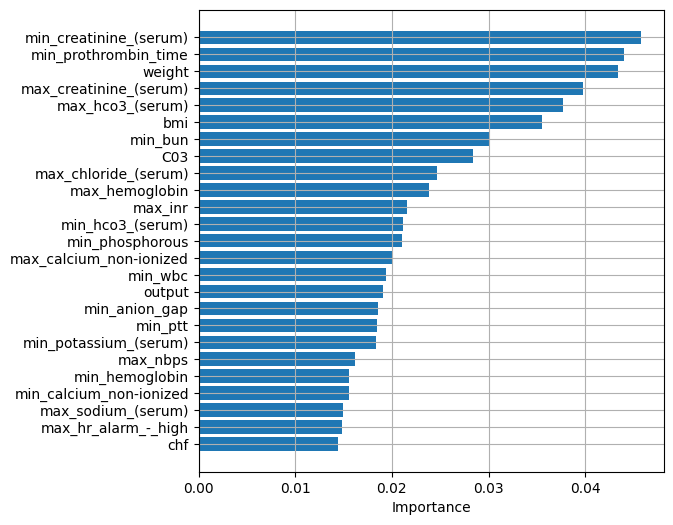

{'min_creatinine_(serum)': 0.045822456,
 'min_prothrombin_time': 0.04404493,
 'weight': 0.04334856,
 'max_creatinine_(serum)': 0.03976196,
 'max_hco3_(serum)': 0.03767893,
 'bmi': 0.035545547,
 'min_bun': 0.030053724,
 'C03': 0.028442811,
 'max_chloride_(serum)': 0.02468965,
 'max_hemoglobin': 0.023823272,
 'max_inr': 0.021583388,
 'min_hco3_(serum)': 0.021200094,
 'min_phosphorous': 0.021038862,
 'max_calcium_non-ionized': 0.020148227,
 'min_wbc': 0.019371,
 'output': 0.01908472,
 'min_anion_gap': 0.018559568,
 'min_ptt': 0.018470915,
 'min_potassium_(serum)': 0.018310796,
 'max_nbps': 0.016207764,
 'min_hemoglobin': 0.0155804865,
 'min_calcium_non-ionized': 0.015531741,
 'max_sodium_(serum)': 0.014979362,
 'max_hr_alarm_-_high': 0.0148045095,
 'chf': 0.014395127}

In [121]:
evaluate(y_true_2, probs_2_unders)
plot_importances(X_data, model_2_unders, top=25)

In [363]:
evaluate(y_true_2, probs_2_unders)

Evaluation..
Best Threshold=0.87, F-Score=0.34
Accuracy: 0.93
F1:  0.33
Sensitivity:  0.39
Precision:  0.28
Specificity:  0.96
PR AUC:  0.19
ROC AUC:  0.67
Confusion matrix:
 [[1215   57]
 [  34   22]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      1272
         1.0       0.28      0.39      0.33        56

    accuracy                           0.93      1328
   macro avg       0.63      0.67      0.64      1328
weighted avg       0.94      0.93      0.94      1328

Precision 20.0% , Sensitivity 0.62 
Precision 25.0% , Sensitivity 0.46 
Precision 33.0% , Sensitivity 0.04 
Precision 33.0% , Sensitivity 0.04 
Precision 33.0% , Sensitivity 0.04 
Precision 33.0% , Sensitivity 0.04 
Precision 100.0% , Sensitivity 0.0 


## With class weights:

In [78]:
model_2_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_2,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)

model_2_weights.fit(
    X_train, 
    y_train_2, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=24.33, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [79]:
# evaluation
print(model_2_weights.classes_)
probs_2_weights = model_2_weights.predict_proba(X_test).T[1] # Predictions
predictions_2_weights = model_2_weights.predict(X_test)
y_true_2 = y_test_2 # True values

[0. 1.]


Evaluation..
Best Threshold=0.03, F-Score=0.30
Accuracy: 0.85
F1:  0.28
Sensitivity:  0.7
Precision:  0.18
Specificity:  0.86
PR AUC:  0.18
ROC AUC:  0.78
Confusion matrix:
 [[1091  181]
 [  17   39]]
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92      1272
         1.0       0.18      0.70      0.28        56

    accuracy                           0.85      1328
   macro avg       0.58      0.78      0.60      1328
weighted avg       0.95      0.85      0.89      1328

Precision 20.0% , Sensitivity 0.43 
Precision 25.0% , Sensitivity 0.16 
Precision 33.0% , Sensitivity 0.07 
Precision 36.0% , Sensitivity 0.07 
Precision 36.0% , Sensitivity 0.07 
Precision 36.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


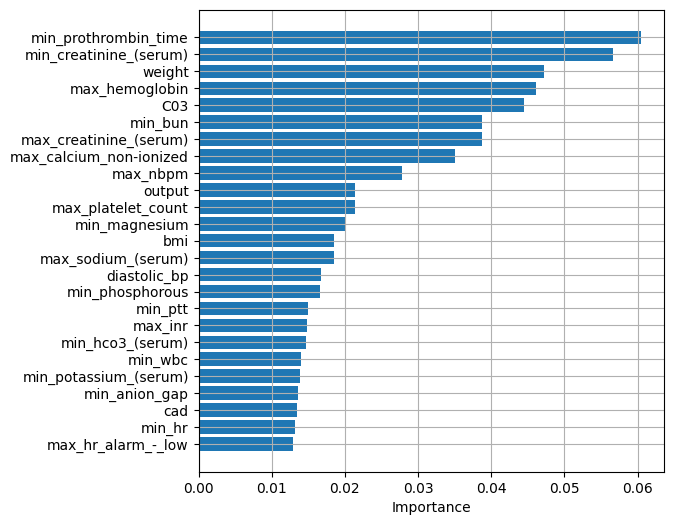

{'min_prothrombin_time': 0.060539275,
 'min_creatinine_(serum)': 0.056687452,
 'weight': 0.047233045,
 'max_hemoglobin': 0.04606482,
 'C03': 0.044511583,
 'min_bun': 0.03879061,
 'max_creatinine_(serum)': 0.0387504,
 'max_calcium_non-ionized': 0.03502157,
 'max_nbpm': 0.027761947,
 'output': 0.021441361,
 'max_platelet_count': 0.02133064,
 'min_magnesium': 0.020154659,
 'bmi': 0.018539371,
 'max_sodium_(serum)': 0.018501356,
 'diastolic_bp': 0.016753817,
 'min_phosphorous': 0.016653445,
 'min_ptt': 0.014927426,
 'max_inr': 0.014820594,
 'min_hco3_(serum)': 0.014734022,
 'min_wbc': 0.01393292,
 'min_potassium_(serum)': 0.013805822,
 'min_anion_gap': 0.013573349,
 'cad': 0.013423905,
 'min_hr': 0.013206423,
 'max_hr_alarm_-_low': 0.012861679}

In [80]:
evaluate(y_true_2, probs_2_weights)
plot_importances(X_data, model_2_weights, top=25)

In [244]:
evaluate(y_true_2, probs_2_weights)

Evaluation..
Best Threshold=0.10, F-Score=0.28
Accuracy: 0.9
F1:  0.26
Sensitivity:  0.43
Precision:  0.19
Specificity:  0.92
PR AUC:  0.18
ROC AUC:  0.67
Confusion matrix:
 [[1170  102]
 [  32   24]]
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      1272
         1.0       0.19      0.43      0.26        56

    accuracy                           0.90      1328
   macro avg       0.58      0.67      0.60      1328
weighted avg       0.94      0.90      0.92      1328

Precision 20.0% , Sensitivity 0.45 
Precision 25.0% , Sensitivity 0.27 
Precision 33.0% , Sensitivity 0.11 
Precision 40.0% , Sensitivity 0.07 
Precision 40.0% , Sensitivity 0.07 
Precision 40.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


### Oversampling

In [104]:
model_2_overs_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_2_overs,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)

model_2_overs_weights.fit(
    X_train_over_2, 
    y_train_over_2, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.0, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [105]:
# evaluation
print(model_2_overs_weights.classes_)
probs_2_overs_weights = model_2_overs_weights.predict_proba(X_test).T[1] # Predictions
predictions_2_overs_weights = model_2_overs_weights.predict(X_test)
y_true_2 = y_test_2 # True values

[0. 1.]


Evaluation..
Best Threshold=0.12, F-Score=0.36
Accuracy: 0.92
F1:  0.35
Sensitivity:  0.52
Precision:  0.27
Specificity:  0.94
PR AUC:  0.24
ROC AUC:  0.73
Confusion matrix:
 [[1192   80]
 [  27   29]]
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      1272
         1.0       0.27      0.52      0.35        56

    accuracy                           0.92      1328
   macro avg       0.62      0.73      0.65      1328
weighted avg       0.95      0.92      0.93      1328

Precision 20.0% , Sensitivity 0.79 
Precision 25.0% , Sensitivity 0.54 
Precision 33.0% , Sensitivity 0.16 
Precision 40.0% , Sensitivity 0.07 
Precision 50.0% , Sensitivity 0.07 
Precision 57.0% , Sensitivity 0.07 
Precision 57.0% , Sensitivity 0.07 


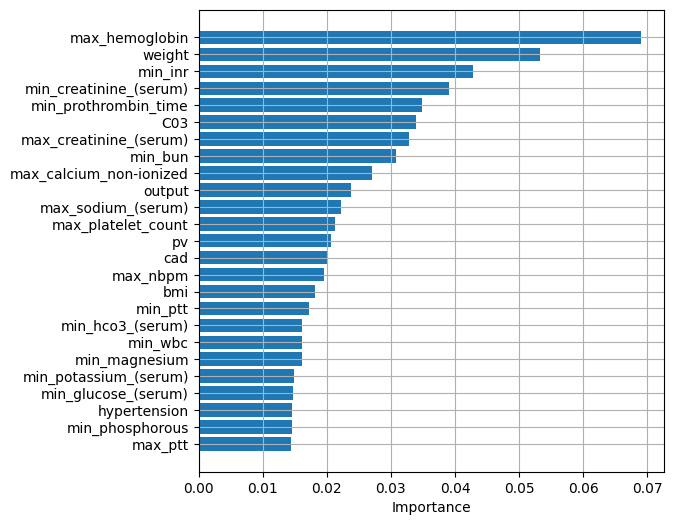

{'max_hemoglobin': 0.069080904,
 'weight': 0.053252716,
 'min_inr': 0.042859416,
 'min_creatinine_(serum)': 0.03902933,
 'min_prothrombin_time': 0.034818534,
 'C03': 0.033941288,
 'max_creatinine_(serum)': 0.032836355,
 'min_bun': 0.030735154,
 'max_calcium_non-ionized': 0.027102318,
 'output': 0.02376562,
 'max_sodium_(serum)': 0.022194628,
 'max_platelet_count': 0.021291966,
 'pv': 0.020599222,
 'cad': 0.02018449,
 'max_nbpm': 0.019486384,
 'bmi': 0.018117044,
 'min_ptt': 0.017242253,
 'min_hco3_(serum)': 0.016170342,
 'min_wbc': 0.016167283,
 'min_magnesium': 0.016055416,
 'min_potassium_(serum)': 0.014946209,
 'min_glucose_(serum)': 0.014676842,
 'hypertension': 0.014647533,
 'min_phosphorous': 0.014535595,
 'max_ptt': 0.014475085}

In [106]:
evaluate(y_true_2, probs_2_overs_weights)
plot_importances(X_data, model_2_overs_weights, top=25)

In [323]:
evaluate(y_true_2, probs_2_overs_weights)

Evaluation..
Best Threshold=0.08, F-Score=0.30
Accuracy: 0.89
F1:  0.29
Sensitivity:  0.5
Precision:  0.2
Specificity:  0.91
PR AUC:  0.2
ROC AUC:  0.71
Confusion matrix:
 [[1160  112]
 [  28   28]]
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      1272
         1.0       0.20      0.50      0.29        56

    accuracy                           0.89      1328
   macro avg       0.59      0.71      0.61      1328
weighted avg       0.94      0.89      0.92      1328

Precision 20.0% , Sensitivity 0.55 
Precision 25.0% , Sensitivity 0.38 
Precision 33.0% , Sensitivity 0.12 
Precision 40.0% , Sensitivity 0.04 
Precision 50.0% , Sensitivity 0.04 
Precision 50.0% , Sensitivity 0.04 
Precision 50.0% , Sensitivity 0.04 


### Undersampling

In [38]:
model_2_unders_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_2_unders,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)

model_2_unders_weights.fit(
    X_train_under_2, 
    y_train_under_2, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [39]:
# evaluation
print(model_2_unders_weights.classes_)
probs_2_unders_weights = model_2_unders_weights.predict_proba(X_test).T[1] # Predictions
predictions_2_unders_weights = model_2_unders_weights.predict(X_test)
y_true_2 = y_test_2 # True values

[0. 1.]


Evaluation..
Best Threshold=0.63, F-Score=0.32
Accuracy: 0.89
F1:  0.31
Sensitivity:  0.57
Precision:  0.21
Specificity:  0.91
PR AUC:  0.22
ROC AUC:  0.74
Confusion matrix:
 [[1155  117]
 [  24   32]]
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      1272
         1.0       0.21      0.57      0.31        56

    accuracy                           0.89      1328
   macro avg       0.60      0.74      0.63      1328
weighted avg       0.95      0.89      0.92      1328

Precision 20.0% , Sensitivity 0.57 
Precision 25.0% , Sensitivity 0.45 
Precision 33.0% , Sensitivity 0.3 
Precision 40.0% , Sensitivity 0.25 
Precision 50.0% , Sensitivity 0.04 
Precision 50.0% , Sensitivity 0.04 
Precision 50.0% , Sensitivity 0.04 


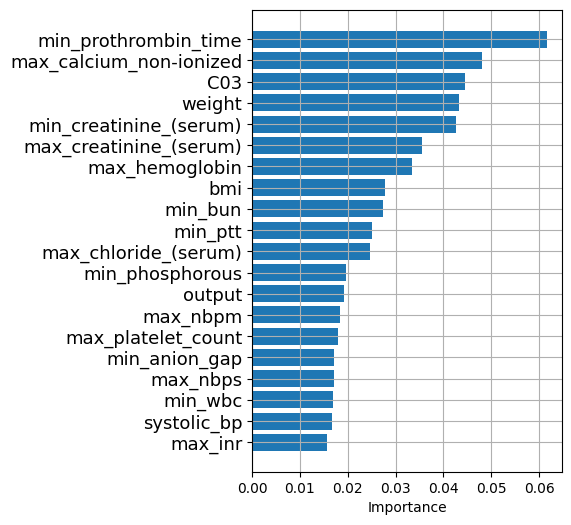

{'min_prothrombin_time': 0.06166875,
 'max_calcium_non-ionized': 0.048146423,
 'C03': 0.04456309,
 'weight': 0.04317614,
 'min_creatinine_(serum)': 0.04260848,
 'max_creatinine_(serum)': 0.03559424,
 'max_hemoglobin': 0.033473887,
 'bmi': 0.027757755,
 'min_bun': 0.027325934,
 'min_ptt': 0.025096873,
 'max_chloride_(serum)': 0.02467011,
 'min_phosphorous': 0.019608265,
 'output': 0.019199368,
 'max_nbpm': 0.018474368,
 'max_platelet_count': 0.017938677,
 'min_anion_gap': 0.017237341,
 'max_nbps': 0.017039925,
 'min_wbc': 0.016925164,
 'systolic_bp': 0.01661252,
 'max_inr': 0.015655395}

In [54]:
evaluate(y_true_2, probs_2_unders_weights)
plot_importances(X_data, model_2_unders_weights, top=20)

In [387]:
evaluate(y_true_2, probs_2_unders_weights)

Evaluation..
Best Threshold=0.80, F-Score=0.36
Accuracy: 0.91
F1:  0.35
Sensitivity:  0.57
Precision:  0.25
Specificity:  0.93
PR AUC:  0.23
ROC AUC:  0.75
Confusion matrix:
 [[1178   94]
 [  24   32]]
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      1272
         1.0       0.25      0.57      0.35        56

    accuracy                           0.91      1328
   macro avg       0.62      0.75      0.65      1328
weighted avg       0.95      0.91      0.93      1328

Precision 20.0% , Sensitivity 0.62 
Precision 25.0% , Sensitivity 0.59 
Precision 33.0% , Sensitivity 0.25 
Precision 40.0% , Sensitivity 0.14 
Precision 40.0% , Sensitivity 0.14 
Precision 40.0% , Sensitivity 0.14 
Precision 100.0% , Sensitivity 0.0 


# AKI 3

## Without class weights:

In [71]:
model_3 = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=9, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)

model_3.fit(
    X_train, 
    y_train_3, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [72]:
# evaluation
print(model_3.classes_)
probs_3 = model_3.predict_proba(X_test).T[1] # Predictions
predictions_3 = model_3.predict(X_test)
y_true_3 = y_test_3 # True values

[0. 1.]


Evaluation..
Best Threshold=0.06, F-Score=0.21
Accuracy: 0.98
F1:  0.21
Sensitivity:  0.2
Precision:  0.23
Specificity:  0.99
PR AUC:  0.07
ROC AUC:  0.6
Confusion matrix:
 [[1303   10]
 [  12    3]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1313
         1.0       0.23      0.20      0.21        15

    accuracy                           0.98      1328
   macro avg       0.61      0.60      0.60      1328
weighted avg       0.98      0.98      0.98      1328

Precision 20.0% , Sensitivity 0.2 
Precision 25.0% , Sensitivity 0.13 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


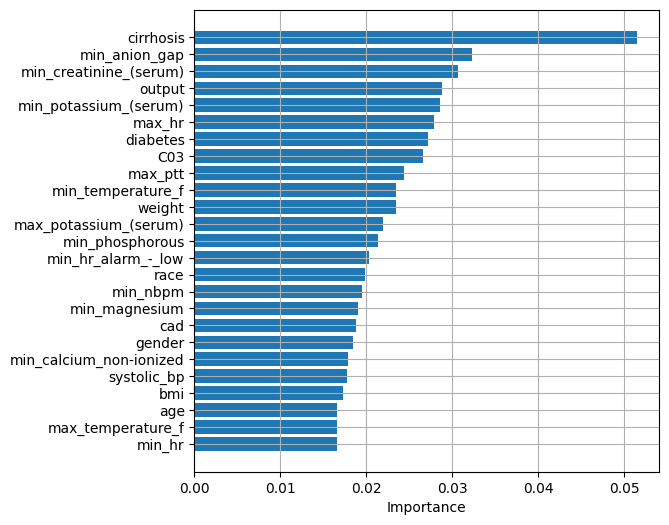

{'cirrhosis': 0.051497772,
 'min_anion_gap': 0.03230123,
 'min_creatinine_(serum)': 0.030644245,
 'output': 0.028830545,
 'min_potassium_(serum)': 0.028567752,
 'max_hr': 0.027856616,
 'diabetes': 0.027198795,
 'C03': 0.026586812,
 'max_ptt': 0.02442343,
 'min_temperature_f': 0.023500748,
 'weight': 0.023496876,
 'max_potassium_(serum)': 0.02193373,
 'min_phosphorous': 0.021353818,
 'min_hr_alarm_-_low': 0.020303093,
 'race': 0.01987262,
 'min_nbpm': 0.019519761,
 'min_magnesium': 0.018980233,
 'cad': 0.018746112,
 'gender': 0.01850632,
 'min_calcium_non-ionized': 0.01786213,
 'systolic_bp': 0.017808676,
 'bmi': 0.017319316,
 'age': 0.016599266,
 'max_temperature_f': 0.016593978,
 'min_hr': 0.016546514}

In [73]:
evaluate(y_true_3, probs_3)
plot_importances(X_data, model_3, top=25)

In [218]:
evaluate(y_true_3, probs_3)

Evaluation..
Best Threshold=0.00, F-Score=0.12
Accuracy: 0.01
F1:  0.02
Sensitivity:  1.0
Precision:  0.01
Specificity:  0.0
PR AUC:  0.05
ROC AUC:  0.5
Confusion matrix:
 [[   0 1313]
 [   0   15]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1313
         1.0       0.01      1.00      0.02        15

    accuracy                           0.01      1328
   macro avg       0.01      0.50      0.01      1328
weighted avg       0.00      0.01      0.00      1328

Precision 20.0% , Sensitivity 0.07 
Precision 25.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


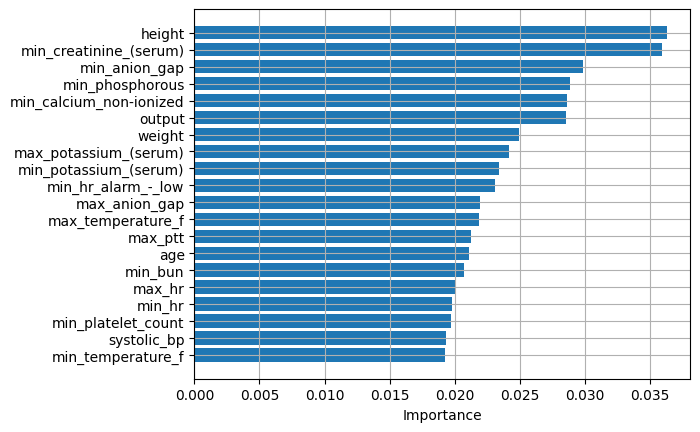

{'height': 0.036262017,
 'min_creatinine_(serum)': 0.035867922,
 'min_anion_gap': 0.029831318,
 'min_phosphorous': 0.028835846,
 'min_calcium_non-ionized': 0.028621484,
 'output': 0.028494628,
 'weight': 0.024890214,
 'max_potassium_(serum)': 0.024142183,
 'min_potassium_(serum)': 0.023422435,
 'min_hr_alarm_-_low': 0.02310587,
 'max_anion_gap': 0.021941677,
 'max_temperature_f': 0.021843163,
 'max_ptt': 0.02122393,
 'age': 0.021082757,
 'min_bun': 0.020714797,
 'max_hr': 0.020035928,
 'min_hr': 0.019775113,
 'min_platelet_count': 0.019683294,
 'systolic_bp': 0.019297387,
 'min_temperature_f': 0.019265827}

In [219]:
plot_importances(X_data, model_3, top=20)

### Oversampling

In [96]:
model_3_overs = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=9, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)

model_3_overs.fit(
    X_train_over_3, 
    y_train_over_3, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [97]:
# evaluation
print(model_3_overs.classes_)
probs_3_overs = model_3_overs.predict_proba(X_test).T[1] # Predictions
predictions_3_overs = model_3_overs.predict(X_test)
y_true_3 = y_test_3 # True values

[0. 1.]


Evaluation..
Best Threshold=0.06, F-Score=0.21
Accuracy: 0.98
F1:  0.21
Sensitivity:  0.2
Precision:  0.23
Specificity:  0.99
PR AUC:  0.07
ROC AUC:  0.6
Confusion matrix:
 [[1303   10]
 [  12    3]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1313
         1.0       0.23      0.20      0.21        15

    accuracy                           0.98      1328
   macro avg       0.61      0.60      0.60      1328
weighted avg       0.98      0.98      0.98      1328

Precision 20.0% , Sensitivity 0.2 
Precision 25.0% , Sensitivity 0.13 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


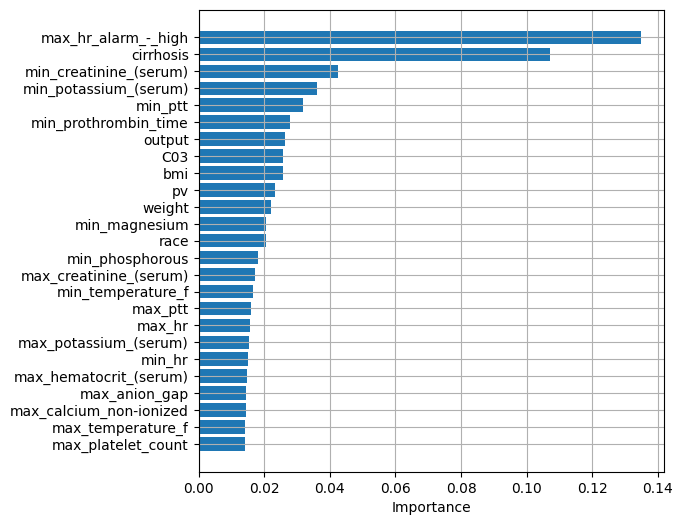

{'max_hr_alarm_-_high': 0.13500236,
 'cirrhosis': 0.10707891,
 'min_creatinine_(serum)': 0.042620044,
 'min_potassium_(serum)': 0.03603467,
 'min_ptt': 0.03191088,
 'min_prothrombin_time': 0.02780778,
 'output': 0.026230372,
 'C03': 0.025676806,
 'bmi': 0.025644984,
 'pv': 0.023242038,
 'weight': 0.022086127,
 'min_magnesium': 0.02063767,
 'race': 0.020633021,
 'min_phosphorous': 0.01819956,
 'max_creatinine_(serum)': 0.017149933,
 'min_temperature_f': 0.016671395,
 'max_ptt': 0.015927285,
 'max_hr': 0.015733778,
 'max_potassium_(serum)': 0.015318803,
 'min_hr': 0.015112361,
 'max_hematocrit_(serum)': 0.014826483,
 'max_anion_gap': 0.01455878,
 'max_calcium_non-ionized': 0.014473485,
 'max_temperature_f': 0.014160975,
 'max_platelet_count': 0.01400809}

In [98]:
evaluate(y_true_3, probs_3)
plot_importances(X_data, model_3_overs, top=25)

In [292]:
evaluate(y_true_3, probs_3)

Evaluation..
Best Threshold=0.00, F-Score=0.12
Accuracy: 0.01
F1:  0.02
Sensitivity:  1.0
Precision:  0.01
Specificity:  0.0
PR AUC:  0.05
ROC AUC:  0.5
Confusion matrix:
 [[   0 1313]
 [   0   15]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1313
         1.0       0.01      1.00      0.02        15

    accuracy                           0.01      1328
   macro avg       0.01      0.50      0.01      1328
weighted avg       0.00      0.01      0.00      1328

Precision 20.0% , Sensitivity 0.07 
Precision 25.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 33.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


### Undersampling

In [122]:
model_3_under = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        # scale_pos_weight=scale_pos_weight,
                        n_estimators=500,
                        min_child_weight=9, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=44)

model_3_under.fit(
    X_train_under_3, 
    y_train_under_3, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=44,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [123]:
# evaluation
print(model_3_under.classes_)
probs_3_unders = model_3_under.predict_proba(X_test).T[1] # Predictions
predictions_3_unders = model_3_under.predict(X_test)
y_true_3 = y_test_3 # True values

[0. 1.]


Evaluation..
Best Threshold=0.43, F-Score=0.19
Accuracy: 0.94
F1:  0.18
Sensitivity:  0.6
Precision:  0.11
Specificity:  0.94
PR AUC:  0.08
ROC AUC:  0.77
Confusion matrix:
 [[1239   74]
 [   6    9]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1313
         1.0       0.11      0.60      0.18        15

    accuracy                           0.94      1328
   macro avg       0.55      0.77      0.58      1328
weighted avg       0.99      0.94      0.96      1328

Precision 17.0% , Sensitivity 0.2 
Precision 17.0% , Sensitivity 0.2 
Precision 17.0% , Sensitivity 0.2 
Precision 17.0% , Sensitivity 0.2 
Precision 17.0% , Sensitivity 0.2 
Precision 100.0% , Sensitivity 0.0 
Precision 100.0% , Sensitivity 0.0 


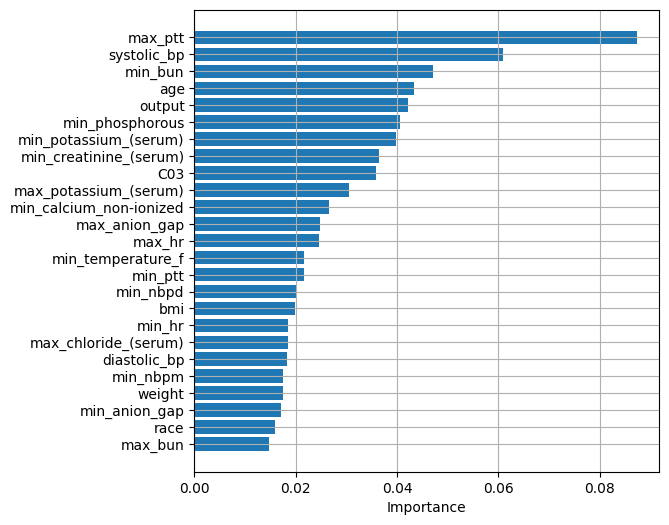

{'max_ptt': 0.087432556,
 'systolic_bp': 0.0608992,
 'min_bun': 0.04715398,
 'age': 0.043458354,
 'output': 0.042215034,
 'min_phosphorous': 0.04065854,
 'min_potassium_(serum)': 0.039745077,
 'min_creatinine_(serum)': 0.036365077,
 'C03': 0.0358526,
 'max_potassium_(serum)': 0.030519104,
 'min_calcium_non-ionized': 0.02666076,
 'max_anion_gap': 0.024897557,
 'max_hr': 0.024695186,
 'min_temperature_f': 0.021639822,
 'min_ptt': 0.02156209,
 'min_nbpd': 0.020081611,
 'bmi': 0.019925088,
 'min_hr': 0.01858662,
 'max_chloride_(serum)': 0.018409863,
 'diastolic_bp': 0.018261462,
 'min_nbpm': 0.017579854,
 'weight': 0.017558144,
 'min_anion_gap': 0.017148914,
 'race': 0.015887057,
 'max_bun': 0.014674611}

In [124]:
evaluate(y_true_3, probs_3_unders)
plot_importances(X_data, model_3_under, top=25)

In [367]:
evaluate(y_true_3, probs_3_unders)

Evaluation..
Best Threshold=0.85, F-Score=0.21
Accuracy: 0.98
F1:  0.11
Sensitivity:  0.13
Precision:  0.1
Specificity:  0.99
PR AUC:  0.06
ROC AUC:  0.56
Confusion matrix:
 [[1294   19]
 [  13    2]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1313
         1.0       0.10      0.13      0.11        15

    accuracy                           0.98      1328
   macro avg       0.54      0.56      0.55      1328
weighted avg       0.98      0.98      0.98      1328

Precision 17.0% , Sensitivity 0.27 
Precision 17.0% , Sensitivity 0.27 
Precision 17.0% , Sensitivity 0.27 
Precision 17.0% , Sensitivity 0.27 
Precision 17.0% , Sensitivity 0.27 
Precision 100.0% , Sensitivity 0.0 
Precision 100.0% , Sensitivity 0.0 


## With class weights

In [83]:
model_3_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_3,
                        n_estimators=500,
                        min_child_weight=7, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)

model_3_weights.fit(
    X_train, 
    y_train_3, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=121.94, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [84]:
# evaluation
print(model_3_weights.classes_)
probs_3_weights = model_3_weights.predict_proba(X_test).T[1] # Predictions
predictions_3_weights = model_3_weights.predict(X_test)
y_true_3 = y_test_3 # True values

[0. 1.]


Evaluation..
Best Threshold=0.06, F-Score=0.18
Accuracy: 0.98
F1:  0.12
Sensitivity:  0.13
Precision:  0.12
Specificity:  0.99
PR AUC:  0.07
ROC AUC:  0.56
Confusion matrix:
 [[1298   15]
 [  13    2]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1313
         1.0       0.12      0.13      0.12        15

    accuracy                           0.98      1328
   macro avg       0.55      0.56      0.56      1328
weighted avg       0.98      0.98      0.98      1328

Precision 20.0% , Sensitivity 0.13 
Precision 25.0% , Sensitivity 0.13 
Precision 29.0% , Sensitivity 0.13 
Precision 29.0% , Sensitivity 0.13 
Precision 29.0% , Sensitivity 0.13 
Precision 29.0% , Sensitivity 0.13 
Precision 100.0% , Sensitivity 0.0 


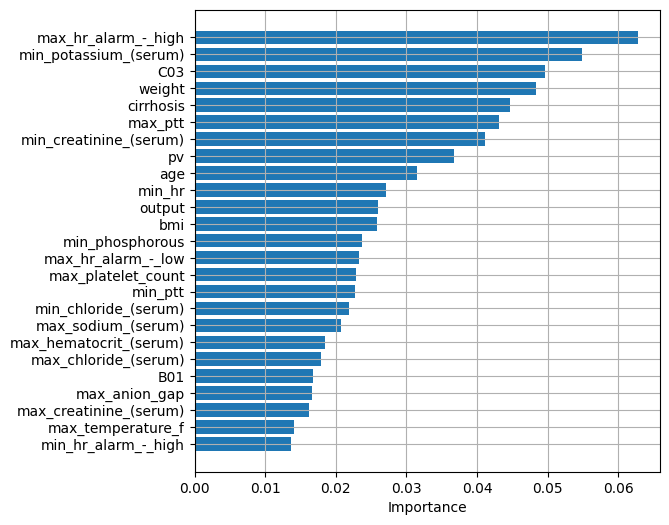

{'max_hr_alarm_-_high': 0.06273965,
 'min_potassium_(serum)': 0.054915845,
 'C03': 0.049676847,
 'weight': 0.048342407,
 'cirrhosis': 0.044656996,
 'max_ptt': 0.043038223,
 'min_creatinine_(serum)': 0.041132316,
 'pv': 0.036702655,
 'age': 0.03141999,
 'min_hr': 0.02709111,
 'output': 0.025963804,
 'bmi': 0.02579066,
 'min_phosphorous': 0.02373497,
 'max_hr_alarm_-_low': 0.023325192,
 'max_platelet_count': 0.022806676,
 'min_ptt': 0.022638872,
 'min_chloride_(serum)': 0.021856477,
 'max_sodium_(serum)': 0.020789193,
 'max_hematocrit_(serum)': 0.018514352,
 'max_chloride_(serum)': 0.017821895,
 'B01': 0.016783873,
 'max_anion_gap': 0.016664928,
 'max_creatinine_(serum)': 0.016237093,
 'max_temperature_f': 0.014022113,
 'min_hr_alarm_-_high': 0.013600874}

In [85]:
evaluate(y_true_3, probs_3_weights)
plot_importances(X_data, model_3_weights, top=25)

In [250]:
evaluate(y_true_3, probs_3_weights)

Evaluation..
Best Threshold=0.03, F-Score=0.21
Accuracy: 0.98
F1:  0.2
Sensitivity:  0.27
Precision:  0.16
Specificity:  0.98
PR AUC:  0.07
ROC AUC:  0.63
Confusion matrix:
 [[1292   21]
 [  11    4]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1313
         1.0       0.16      0.27      0.20        15

    accuracy                           0.98      1328
   macro avg       0.58      0.63      0.59      1328
weighted avg       0.98      0.98      0.98      1328

Precision 20.0% , Sensitivity 0.13 
Precision 25.0% , Sensitivity 0.13 
Precision 25.0% , Sensitivity 0.13 
Precision 25.0% , Sensitivity 0.13 
Precision 25.0% , Sensitivity 0.13 
Precision 25.0% , Sensitivity 0.13 
Precision 100.0% , Sensitivity 0.0 


### Oversampling

In [107]:
model_3_overs_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_3_overs,
                        n_estimators=500,
                        min_child_weight=9, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)

model_3_overs_weights.fit(
    X_train_over_3, 
    y_train_over_3, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.0, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [108]:
# evaluation
print(model_3_overs_weights.classes_)
probs_3_overs_weights = model_3_overs_weights.predict_proba(X_test).T[1] # Predictions
predictions_3_overs_weights = model_3_overs_weights.predict(X_test)
y_true_3 = y_test_3 # True values

[0. 1.]


Evaluation..
Best Threshold=0.02, F-Score=0.24
Accuracy: 0.97
F1:  0.2
Sensitivity:  0.33
Precision:  0.15
Specificity:  0.98
PR AUC:  0.08
ROC AUC:  0.66
Confusion matrix:
 [[1284   29]
 [  10    5]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1313
         1.0       0.15      0.33      0.20        15

    accuracy                           0.97      1328
   macro avg       0.57      0.66      0.59      1328
weighted avg       0.98      0.97      0.98      1328

Precision 20.0% , Sensitivity 0.2 
Precision 25.0% , Sensitivity 0.07 
Precision 25.0% , Sensitivity 0.07 
Precision 25.0% , Sensitivity 0.07 
Precision 25.0% , Sensitivity 0.07 
Precision 25.0% , Sensitivity 0.07 
Precision 100.0% , Sensitivity 0.0 


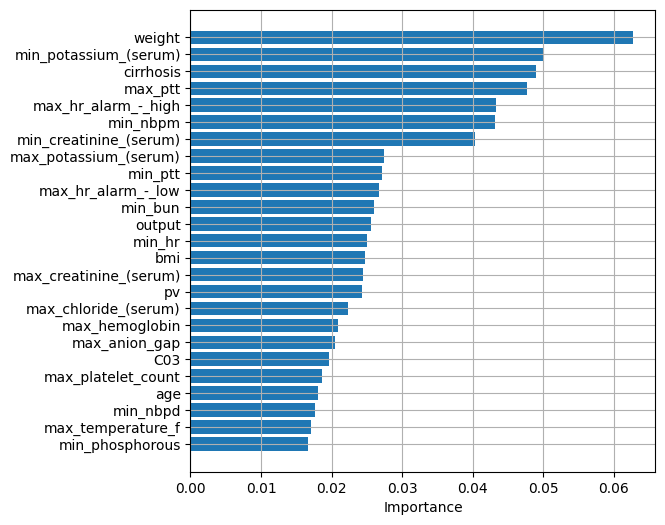

{'weight': 0.06276789,
 'min_potassium_(serum)': 0.04996322,
 'cirrhosis': 0.048985265,
 'max_ptt': 0.047704622,
 'max_hr_alarm_-_high': 0.04325281,
 'min_nbpm': 0.04311803,
 'min_creatinine_(serum)': 0.04026968,
 'max_potassium_(serum)': 0.027392277,
 'min_ptt': 0.027126309,
 'max_hr_alarm_-_low': 0.026777055,
 'min_bun': 0.02597617,
 'output': 0.025534172,
 'min_hr': 0.025037812,
 'bmi': 0.024667207,
 'max_creatinine_(serum)': 0.024436738,
 'pv': 0.024365542,
 'max_chloride_(serum)': 0.022283554,
 'max_hemoglobin': 0.020976335,
 'max_anion_gap': 0.020426847,
 'C03': 0.01962978,
 'max_platelet_count': 0.01857713,
 'age': 0.018038977,
 'min_nbpd': 0.017593075,
 'max_temperature_f': 0.017097319,
 'min_phosphorous': 0.016596546}

In [109]:
evaluate(y_true_3, probs_3_overs_weights)
plot_importances(X_data, model_3_overs_weights, top=25)

In [326]:
evaluate(y_true_3, probs_3_overs_weights)

Evaluation..
Best Threshold=0.09, F-Score=0.15
Accuracy: 0.98
F1:  0.15
Sensitivity:  0.13
Precision:  0.17
Specificity:  0.99
PR AUC:  0.05
ROC AUC:  0.56
Confusion matrix:
 [[1303   10]
 [  13    2]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1313
         1.0       0.17      0.13      0.15        15

    accuracy                           0.98      1328
   macro avg       0.58      0.56      0.57      1328
weighted avg       0.98      0.98      0.98      1328

Precision 17.0% , Sensitivity 0.13 
Precision 17.0% , Sensitivity 0.13 
Precision 17.0% , Sensitivity 0.13 
Precision 17.0% , Sensitivity 0.13 
Precision 17.0% , Sensitivity 0.13 
Precision 100.0% , Sensitivity 0.0 
Precision 100.0% , Sensitivity 0.0 


### Undersampling

In [49]:
model_3_unders_weights = XGBClassifier(  tree_method='auto',
                        max_depth=3,
                        scale_pos_weight=scale_pos_weight_3_unders,
                        n_estimators=500,
                        min_child_weight=9, 
                        colsample_bytree=1, 
                        subsample=1, 
                        eta=0.3,    
                        seed=42)

model_3_unders_weights.fit(
    X_train_under_3, 
    y_train_under_3, 
    eval_metric="aucpr", 
    # eval_set=[(X_train, y_train.T[w]), (X_val, y_val.T[w])], 
    verbose=False)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.0, seed=42,
              subsample=1, tree_method='auto', validate_parameters=1,
              verbosity=None)

In [50]:
# evaluation
print(model_3_unders_weights.classes_)
probs_3_unders_weights = model_3_unders_weights.predict_proba(X_test).T[1] # Predictions
predictions_3_unders_weights = model_3_unders_weights.predict(X_test)
y_true_3 = y_test_3 # True values

[0. 1.]


Evaluation..
Best Threshold=0.95, F-Score=0.28
Accuracy: 0.98
F1:  0.24
Sensitivity:  0.27
Precision:  0.21
Specificity:  0.99
PR AUC:  0.12
ROC AUC:  0.63
Confusion matrix:
 [[1298   15]
 [  11    4]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1313
         1.0       0.21      0.27      0.24        15

    accuracy                           0.98      1328
   macro avg       0.60      0.63      0.61      1328
weighted avg       0.98      0.98      0.98      1328

Precision 20.0% , Sensitivity 0.33 
Precision 25.0% , Sensitivity 0.27 
Precision 33.0% , Sensitivity 0.2 
Precision 38.0% , Sensitivity 0.2 
Precision 43.0% , Sensitivity 0.2 
Precision 43.0% , Sensitivity 0.2 
Precision 100.0% , Sensitivity 0.0 


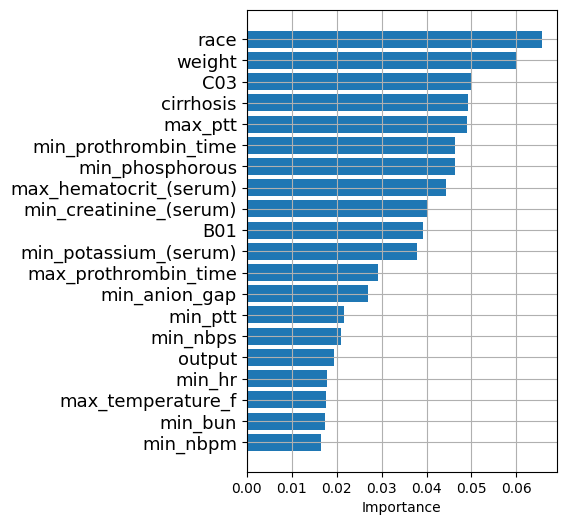

{'race': 0.06568435,
 'weight': 0.059946116,
 'C03': 0.05021021,
 'cirrhosis': 0.049213592,
 'max_ptt': 0.048898015,
 'min_prothrombin_time': 0.04627541,
 'min_phosphorous': 0.046261188,
 'max_hematocrit_(serum)': 0.044377215,
 'min_creatinine_(serum)': 0.04043435,
 'B01': 0.039328765,
 'min_potassium_(serum)': 0.037828624,
 'max_prothrombin_time': 0.029235475,
 'min_anion_gap': 0.026885483,
 'min_ptt': 0.021559743,
 'min_nbps': 0.020891758,
 'output': 0.01951208,
 'min_hr': 0.017903863,
 'max_temperature_f': 0.017618252,
 'min_bun': 0.01748243,
 'min_nbpm': 0.01663159}

In [55]:
evaluate(y_true_3, probs_3_unders_weights)
plot_importances(X_data, model_3_unders_weights, top=20)

In [390]:
evaluate(y_true_3, probs_3_unders_weights)

Evaluation..
Best Threshold=0.88, F-Score=0.18
Accuracy: 0.97
F1:  0.18
Sensitivity:  0.27
Precision:  0.13
Specificity:  0.98
PR AUC:  0.06
ROC AUC:  0.62
Confusion matrix:
 [[1287   26]
 [  11    4]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1313
         1.0       0.13      0.27      0.18        15

    accuracy                           0.97      1328
   macro avg       0.56      0.62      0.58      1328
weighted avg       0.98      0.97      0.98      1328

Precision 14.0% , Sensitivity 0.2 
Precision 14.0% , Sensitivity 0.2 
Precision 14.0% , Sensitivity 0.2 
Precision 14.0% , Sensitivity 0.2 
Precision 14.0% , Sensitivity 0.2 
Precision 100.0% , Sensitivity 0.0 
Precision 100.0% , Sensitivity 0.0 


# Evaluation

In [35]:
def evaluate(y_true, probs, calculate_threshold=True):
    print('Evaluation..')
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx


    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    precision, recall, thresholds = np.round(precision, 2), np.round(recall,2), np.round(thresholds,2)
    
    # convert to f score
    fscore = np.round((2 * precision * recall) / (precision + recall + 0.000001), 2)

    if calculate_threshold:
        # locate the index of the largest f score
        ix = np.argmax(np.nan_to_num(fscore))
        threshold = np.round(thresholds[ix], 3)
        print('Best Threshold=%.2f, F-Score=%.2f' % (threshold, fscore[ix]))

    y_pred = (probs >= threshold).astype(int)

    accuracy = np.round(accuracy_score(y_true, y_pred), 2)
    print(f'Accuracy: {accuracy}')

    f1_score_ = np.round(f1_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
    print(f'F1: ', f1_score_)

    recall_score_ = np.round(recall_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
    print(f'Sensitivity: ', recall_score_)

    precision_score_ = np.round(precision_score(y_true, y_pred, pos_label=1, average='binary', zero_division=0), 2)
    print(f'Precision: ', precision_score_)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity =  np.round(tn / (tn + fp), 2)
    print(f'Specificity: ', specificity)

    pr_auc = np.round(auc(recall, precision), 2) 
    print(f'PR AUC: ', pr_auc)

    roc_auc = np.round(roc_auc_score(y_true, y_pred), 2)
    print(f'ROC AUC: ', roc_auc)
    # confusion matrix
    print(f'Confusion matrix:\n', confusion_matrix(y_true, y_pred))
    # get classification metrics for all samples in the test set
    classification_report_res = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    print(classification_report(y_true, y_pred, zero_division=0, output_dict=False))
    # operating points 
    precision_list = [0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.75]
    for p in precision_list:
        idx = find_nearest(precision, p)
        sensitivity = recall[idx]
        print(f'Precision {np.round(precision[idx]*100, 1)}% , Sensitivity {sensitivity} ')

    return

In [56]:
train

,subject_id,hadm_id,stay_id,bmi,height,weight,diastolic_bp,systolic_bp,min_sodium_(serum),max_chloride_(serum),...,C03,C02,cirrhosis,cad,chf,liver,mi,diabetes,hypertension,pv
0,10002155,28994087,31090461,21.4,60.0,109.4,51.0,99.0,136.0,106.0,...,0,0,0,1,1,0,1,0,1,0
1,10002428,20321825,34807493,20.0,59.0,99.0,78.0,131.0,133.0,93.0,...,0,0,0,0,0,0,0,0,1,0
2,10002428,23473524,35479615,20.0,59.0,99.0,78.0,131.0,135.0,107.0,...,0,0,0,0,0,0,0,0,1,0
3,10002428,28662225,33987268,20.0,59.0,99.0,78.0,131.0,133.0,98.0,...,0,0,0,0,0,0,0,0,1,0
4,10002428,28662225,38875437,20.0,59.0,99.0,78.0,131.0,144.0,110.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33800,15993533,29621245,34059206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
33801,16045643,25632457,36737306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
33802,16821470,23605278,32690638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
33803,18592890,27485579,31682115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
